<a href="https://colab.research.google.com/github/tccoleman26/zartico_things/blob/main/Path_Segment_Simplification_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Ramer Douglas Peucker Algorithm with a Path Segmentation Framework

P. Taylor Coleman

# Import/Install Python Packages and Code

In [ ]:
#@title
#!apt-get install -qq curl g++ make subversion
##!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
#!svn checkout https://github.com/jbremz/Beijing-Trajectories-Project/tree/trunk/

#os.chdir('spatialindex-src-1.8.5')
#!./configure
##!make
#!make install
#!pip install rtree
#!ldconfig

In [ ]:
#@title
!pip install scikit-mobility


     |████████████████████████████████| 154 kB 8.4 MB/s 
     |████████████████████████████████| 793 kB 49.9 MB/s 
     |████████████████████████████████| 95 kB 5.3 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 994 kB 43.6 MB/s 
     |████████████████████████████████| 16.7 MB 39.4 MB/s 
     |████████████████████████████████| 6.3 MB 33.9 MB/s 
     |████████████████████████████████| 3.1 MB 27.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but 

In [ ]:
#@title
# General Use
from google.colab import drive
import datetime
import zipfile
import random
import os

# Plotting
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import skmob # This is not a plotting Package, but I really like the visualization


# Computational
from numpy import arctan2, random, sin, cos, degrees
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance
from scipy.stats import zscore
from math import radians, pi, ceil
import pandas as pd
import numpy as np
from random import gauss

# Model Selection

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# GeoSpatial
from shapely.geometry import Point, LineString
import shapely


drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
#@title
def get_df(ts_list, pt_list, noise=False):
    """
    Args:
       ts_list (int): A list of timestamps 
       pt_list (tuple): 

    Returns:
        pd.DataFrame
    """
    df = pd.DataFrame({'time(s)': ts_list, 'start_point':pt_list})
    df['end_point'] = df['start_point'].shift(-1)
    df = df_turn_points_to_columns(df, 'start_point', 'end_point')  
    df = df.dropna()
    df['bearings']  = df.apply(lambda x: bearings(x['start_point_x'], x['start_point_y'], x['end_point_x'], x['end_point_y']),axis=1)
    df['distance'] = df.apply(lambda x: distance.euclidean(x['start_point'], x['end_point']), axis=1) 
    df['velocity'] = df['distance'] / 3
    if noise:
        noise_cols = [col + "_noise" for col in df.columns]
        noise_cols[0] = 'time(s)'
        df.columns = noise_cols

    return df

def get_bearing_velocity_distance_simp_df(simp_pdf):
    """
    """
    simp_pdf['ground_truth_x']= simp_pdf['simplified_x']#.to_list()
    simp_pdf['ground_truth_y']= simp_pdf['simplified_x']#
    simp_pdf['time(s)'] = [i*3 for i in range(len(simp_pdf['ground_truth_x']))]
    simp_pdf['start_point_gt'] = simp_pdf.apply(lambda x: (x['ground_truth_x'], x['ground_truth_y']),axis=1)
    simp_pdf['end_point_gt'] = simp_pdf['start_point_gt'].shift(-1).reset_index(drop=True)
    simp_pdf['ground_truth_x']= simp_pdf['simplified_x']#.to_list()
    simp_pdf['ground_truth_y']= simp_pdf['simplified_x']#
    simp_pdf['time(s)'] = [i*3 for i in range(len(simp_pdf['ground_truth_x']))]
    simp_pdf['start_point_gt'] = simp_pdf.apply(lambda x: (x['ground_truth_x'], x['ground_truth_y']),axis=1)
    simp_pdf['end_simplified_x'] = simp_pdf['simplified_x'].shift(-1)#.reset_index(drop=True)
    simp_pdf['end_simplified_y'] = simp_pdf['simplified_y'].shift(-1)#.reset_index(drop=True)
    simp_pdf['end_simplified_points'] = simp_pdf['simplified_points'].shift(-1)#.reset_index(drop=True)
    simp_pdf = simp_pdf.reset_index(drop=True).dropna()
    
    simp_pdf['bearings_simp']  = simp_pdf.apply(lambda x: bearings(x['simplified_x'], x['simplified_y'], x['end_simplified_x'], x['end_simplified_y']),axis=1)
    simp_pdf['distance_simp'] = simp_pdf.apply(lambda x: distance.euclidean(x['simplified_points'], x['end_simplified_points']), axis=1)

    simp_pdf['velocity_simp'] = simp_pdf['distance_simp'] / 3

    simp_pdf['dist_gt'] = simp_pdf.apply(lambda x: distance.euclidean(x['start_point_gt'], x['end_point_gt']), axis=1) 
    simp_pdf['bearing_gt'] = 45
    simp_pdf['velocity_gt'] = 0.471405 # THis is not quite true but close enough

    return simp_pdf


def merge_df_noisy_df(ground_truth_df, noisy_df):
    df = pd.concat([ground_truth_df, noisy_df],axis=1)
    return df.iloc[:, 1:]


def df_turn_points_to_columns(df, start_point_column, end_point_columns):

    df[[start_point_column + "_x",start_point_column +"_y"]] = df[start_point_column].apply(pd.Series)
    df[[end_point_columns +"_x",end_point_columns +"_y"]] = df[end_point_columns].apply(pd.Series)
    return df

  
def bearings(lon_1,lat_1,lon_2,lat_2, round_num=True):
    """
    Get bearings between lon_1, lat1_, and lon_2, lat_2
    https://www.movable-type.co.uk/scripts/latlong.html
    """
    lon_1, lat_1, lon_2, lat_2 = radians(lon_1), radians(lat_1), radians(lon_2), radians(lat_2)


    dl = lon_2-lon_1
    x = cos(lat_2)*sin(dl)
    y = cos(lat_1)*sin(lat_2) - sin(lat_1)*cos(lat_2)* cos(dl)
    bearing = arctan2(x,y)
    if round_num:
        return ceil(bearing*180/pi)
    else:
        return bearing*180/pi

def plot_position(df, run_number, number_of_runs):
    
    fig = make_subplots(rows=number_of_runs, cols=1)
    
    
    data = [
        go.Scatter(x=df['start_point_x'], y=df['start_point_y'], mode='markers', name='Ground Truth'),
        go.Scatter(x=df['start_point_x_noise'], y=df['start_point_y_noise'], mode='markers+lines', name = 'Position with Noise')
   ]

    fig = go.Figure(data=data, layout=dict(height=450, width=550))

    fig.update_layout(title_text='Y vs X with Noise Run {0}'.format(run_number), title_x=0.5)
    fig.show()


def rdp_simplify(noisy_df, noisy_point_column='start_point_noise', tolerance=1):
    coordinates = list(LineString(noisy_df[noisy_point_column]).simplify(tolerance).coords)
    df = pd.DataFrame(coordinates, columns=['simplified_x','simplified_y'])
    df['simplified_points'] = df.apply(lambda x: (x['simplified_x'], x['simplified_y']), axis=1)
    return df


def plot_position_gd_df(ground_truth_df, simplified_df, run_number, number_of_runs):
    
    fig = make_subplots(rows=1, cols=number_of_runs)

    data = [
        go.Scatter(x=ground_truth_df['start_point_x'], y=ground_truth_df['start_point_y'], mode='markers', name='Ground Truth'),
        go.Scatter(x=simplified_df['simplified_x'], y=simplified_df['simplified_y'], mode='markers+lines', name = 'Simplified VW Path')
   ]

    fig = go.Figure(data=data, layout=dict(height=450, width=550))

    fig.update_layout(title_text='Simplified Y vs X with Noise Run {0}'.format(run_number), title_x=0.5)
    fig.show()
    
    

# Abstract
---

Sensor Drift/Noise affects measurements of Mobile Collection units such as GPS, Phones, and Third Party vendors. This drift then causes inaccuracy in data collection. To resolve this, we propose using prelabeled transportation method data (train, walking, taxi, etc) to train the supervised classification algorithms Random Forests and XGBoost. And then appling a specific Ramer Douglas Peucker Algorithm tolerance to each type of trainsportation, by chaining consectutive points of the same kind of transport together. This method worked well for the classification by scoring between a 90-92% for Random Forests and XGBoost. The preset tolerances also worked well, but more investigation for different subgroups of transportation types (walking down the street vs walking in a store).

# Introduction
---
Sensor noise can affect the certainty of where an entity is in space. For example, if an entity is walking down Rodeo Drive in Beverly hills, we can surmise that the person is walking on the sidewalk, and not in the middle of the street. However, if the GPS data has intermittent sampling and the entity is in the middle of the street and moving under 3 Miles per Hour, at a near constant rate, that is probably a person and not a car. And that phenomenon is called sensor drift [1]. 



# Literature Review
---

Some researchers have used Convulational Neural Networks by treating each of the trajectory on a map as an image and classifying the type of the total trajectory. This might be something to keep as we are moving forward, but I don't think this is quite what we are looking for.
[https://github.com/jbremz/Beijing-Trajectories-Project/blob/master/Classification/Classification%20Notes.ipynb]

The literature on Path Segmentation (or lack thereof) is more interesting. Path Segmentation is the process of breaking down each trajectory into pieces, turning those pieces into different variables (Bearing, Velocity, Displacement, Straightness) and so forth.  [https://movementecologyjournal.biomedcentral.com/articles/10.1186/s40462-016-0086-5]

There is continuing research on the type of algorithms that you are using, and the result is if you have data that is prelabeled available (like I do) then go with building a classifier. If you do not, probably go with an unsupervised algorithm such as DBSCAN or KMeans. [https://www.sciencedirect.com/science/article/abs/pii/S0021929004002258?via%3Dihub
Data Resources]

[link text](https://)There is a great need for algorithms like this since, the errors from sensor noise might be greater than the step size itsef [https://besjournals.onlinelibrary.wiley.com/doi/10.1111/1365-2656.13610]





#Methodology
----
### Ground Truth Line 

### Line With Noise

A baseline of $y=x$ was chosen for simplicity [Figure 1, Table 1], before noise was added. Instead of being constants, the secondary variables (bearing, velocity, and distance) will now change as a result. To simulate and demonstrate this, let's assume that the noise is Gaussian with a mean of 0 and a standard deviation of 1 across 8 different runs. And the point column will be $\vec{P} = \vec{P}_\text{ground_truth} + \mathcal{N}(μ,\,\sigma^{2}) $ and $\mathcal{N}(0,\,1) $ is a Gaussian Distribution with a mean of $0$ and a standard deviation of 1. 
*italicized text*

## Y vs X
![Figure 1](https://drive.google.com/uc?export=view&id=1k2NxDa7xhskRHapXNHbzz19bio17LKZ3)

**Figure 1**

||   time(s) | start_point   | end_point   |   bearings |   distance |   velocity |
|---:|----------:|:--------------|:------------|-----------:|-----------:|-----------:|
|  0 |         0 | (0, 0)        | (1, 1)      |         45 |    1.41421 |   0.471405 |
|  1 |         3 | (1, 1)        | (2, 2)      |         45 |    1.41421 |   0.471405 |
|  2 |         6 | (2, 2)        | (3, 3)      |         45 |    1.41421 |   0.471405 |
|  3 |         9 | (3, 3)        | (4, 4)      |         45 |    1.41421 |   0.471405 |
|  4 |        12 | (4, 4)        | (5, 5)      |         45 |    1.41421 |   0.471405 |

**Table 1**


### Correlation of the Variables for the Ground Truth

After which, the Pearson Correlation Coefficient  $r = \frac{{}\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}
{\sqrt{\sum_{i=1}^{n} (x_i - \overline{x})^2(y_i - \overline{y})^2}}$ to look at the predictive effect of noise of the variables for the ground truth. The columns of velocity, bearings, and distance have been dropped from the correlation matrix because there is no variance for the ground truth since the value is constant $(x_i = \overline{x})$. 



# Results
----

### Part 1 Results

#### Line Results

The Red Dots are the noise added from the standard deviation.
![Figure 2](https://drive.google.com/uc?export=view&id=1kbnCpxzr1ExLHzg-1336VBwdQD4_HdSa)

**Figure 2**



The correlation of the variables to the start and the end point can be seen [Figure 3], where $f(bearings_\text{noise}, distance_\text{noise})$ or $f(bearings_\text{noise}, velocity_\text{noise}, time(s))$. Which makes sense since the position of $P_{i}$ is a the function of distance and bearing $f(bearings, distance)$ or  $f(bearings, velocity, time(s))$ 

The original bearing has a correlection coeffiecient of 0.91 as when compared to the start_point and the end point respectively. But then when looking at the bearing_noisy, that drop towards to the 0.2 range to the 0.3 range approximately.

![Figure 2](https://drive.google.com/uc?export=view&id=1D_dd0J9dA9G4lIJxee7FIUgrFFSwI3u5)

**Figure 3**




In [ ]:
#@title
ts_list = [i*3 for i in range(30)]
point_list = [(i,i) for i in range(30)]

ground_truth_pdf = get_df(ts_list, point_list, noise =False)
ground_truth_pdf.iloc[0:5] # Only so the dataframe doesn't take up the entire screen

fig = px.line(ground_truth_pdf.rename({'start_point_x':'x','start_point_y':'y'},axis=1), x="x", y="y", title='Y vs X Trajectory',  markers=True)
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [ ]:
#@title
print(ground_truth_pdf.iloc[0:5][['time(s)','start_point','end_point','bearings','distance','velocity']].to_latex(index=False))

\begin{tabular}{rllrrr}
\toprule
 time(s) & start\_point & end\_point &  bearings &  distance &  velocity \\
\midrule
       0 &      (0, 0) &    (1, 1) &        45 &  1.414214 &  0.471405 \\
       3 &      (1, 1) &    (2, 2) &        45 &  1.414214 &  0.471405 \\
       6 &      (2, 2) &    (3, 3) &        45 &  1.414214 &  0.471405 \\
       9 &      (3, 3) &    (4, 4) &        45 &  1.414214 &  0.471405 \\
      12 &      (4, 4) &    (5, 5) &        45 &  1.414214 &  0.471405 \\
\bottomrule
\end{tabular}



In [ ]:
#@title
noisy_df_list = []
joined_df_list = []
for i in range(8):

    point_list = [(i+gauss(0,1) ,i+gauss(0,1)) for i in range(30)]
    noisy_df = get_df(ts_list, point_list, noise=True)
    noisy_df_list.append(noisy_df)
    joined_df = merge_df_noisy_df(ground_truth_pdf, noisy_df)   
    joined_df_list.append(joined_df)
    plot_position(joined_df, i+1, 8)

In [ ]:
print(noisy_df_list[0][['start_point_noise','end_point_noise','bearings_noise','distance_noise','velocity_noise']].iloc[0:5].to_latex(index=False, float_format="{:0.2f}".format))

\begin{tabular}{llrrr}
\toprule
                        start\_point\_noise &                          end\_point\_noise &  bearings\_noise &  distance\_noise &  velocity\_noise \\
\midrule
(0.1795393520577449, -0.1567655719733551) &  (2.229248402588585, -0.842950293925947) &             109 &            2.16 &            0.72 \\
  (2.229248402588585, -0.842950293925947) &  (3.871726236198665, 1.7832776999404167) &              33 &            3.10 &            1.03 \\
  (3.871726236198665, 1.7832776999404167) &   (2.92544299357927, 3.7824961145734077) &             -25 &            2.21 &            0.74 \\
   (2.92544299357927, 3.7824961145734077) & (3.5077299233282186, 3.4610496294043673) &             119 &            0.67 &            0.22 \\
 (3.5077299233282186, 3.4610496294043673) &  (4.658369284292946, 5.0031042215122445) &              37 &            1.92 &            0.64 \\
\bottomrule
\end{tabular}



In [ ]:
u = np.array([*pdf['start_point_noise']])
v = np.array([*pdf['start_point']])
hdist = distance.directed_hausdorff(u,v)
hd_dist.append(hdist)
run_list.append(i+1)

hd_df = pd.DataFrame({'run':run_list,'hasdorff_distance':hd_dist})
hd_df['hasdorff_distance'] = hd_df['hasdorff_distance'].apply(pd.Series)[[0]]
hd_df

In [ ]:
import pandas as pd
degrees = [1, 0.1, .01, .001, 0.0001, 0.00001, 0.000001]
distance = ['111 km', '11.1 km', '1.11 km', '111 m', '11.1 m', '1.11 m', '0.111 m']

dist_df = pd.DataFrame({'degrees':degrees,'distance': distance})
print(dist_df.to_latex(index=False))

\begin{tabular}{rl}
\toprule
 degrees & distance \\
\midrule
1.000000 &   111 km \\
0.100000 &  11.1 km \\
0.010000 &  1.11 km \\
0.001000 &    111 m \\
0.000100 &   11.1 m \\
0.000010 &   1.11 m \\
0.000001 &  0.111 m \\
\bottomrule
\end{tabular}



In [ ]:
transport_type = ['walking', 'bike', 'car/bus','train','plane']
tolerance = [(3.18*10**-5), (5*3.18*10**-5), (11*10**-5), (11*10**-5), (111*10**-5)]
reason = ['Width of Commerical Sidewalk', 'One Side of the Average Road','Width of the Average Road','Width of the Average Road','111 Meters']

foo = pd.DataFrame({'Transport Type':transport_type,'Tolerance':tolerance, 'Justification': reason}).to_latex(index=False)
print(foo)

\begin{tabular}{lrl}
\toprule
Transport Type &  Tolerance &                Justification \\
\midrule
       walking &   0.000032 & Width of Commerical Sidewalk \\
          bike &   0.000159 & One Side of the Average Road \\
       car/bus &   0.000110 &    Width of the Average Road \\
         train &   0.000110 &    Width of the Average Road \\
         plane &   0.001110 &                   111 Meters \\
\bottomrule
\end{tabular}



In [ ]:
print(joined_df_list[0][['time(s)','start_point','start_point_noise','end_point_noise','bearings','bearings_noise','distance','distance_noise','velocity','velocity_noise']].iloc[:5].to_latex(index=False))

\begin{tabular}{rlllrrrrrr}
\toprule
 time(s) & start\_point &                         start\_point\_noise &                          end\_point\_noise &  bearings &  bearings\_noise &  distance &  distance\_noise &  velocity &  velocity\_noise \\
\midrule
       0 &      (0, 0) & (0.1795393520577449, -0.1567655719733551) &  (2.229248402588585, -0.842950293925947) &        45 &             109 &  1.414214 &        2.161517 &  0.471405 &        0.720506 \\
       3 &      (1, 1) &   (2.229248402588585, -0.842950293925947) &  (3.871726236198665, 1.7832776999404167) &        45 &              33 &  1.414214 &        3.097549 &  0.471405 &        1.032516 \\
       6 &      (2, 2) &   (3.871726236198665, 1.7832776999404167) &   (2.92544299357927, 3.7824961145734077) &        45 &             -25 &  1.414214 &        2.211860 &  0.471405 &        0.737287 \\
       9 &      (3, 3) &    (2.92544299357927, 3.7824961145734077) & (3.5077299233282186, 3.4610496294043673) &        45 &           

In [ ]:
u = np.array([*pdf['start_point_noise']])
v = np.array([*pdf['start_point']])
hdist = distance.directed_hausdorff(u,v)
hd_dist.append(hdist)
run_list.append(i+1)

hd_df = pd.DataFrame({'run':run_list,'hasdorff_distance':hd_dist})
hd_df['hasdorff_distance'] = hd_df['hasdorff_distance'].apply(pd.Series)[[0]]
hd_df

#### Correlation Results:

The values that seem to have the highest effect on the columns start_point and end_point (x,y) are a $f(bearings_\text{noise}, distance_\text{noise})$ or $f(bearings_\text{noise}, velocity_\text{noise}, time(s))$. Which makes sense since the position of $P_{i}$ is a the function of distance and bearing $f(bearings, distance)$ or  $f(bearings, velocity, time(s))$ 

The original bearing has a correlection coeffiecient of 0.91 as when compared to the start_point and the end point respectively. But then when looking at the bearing_noisy, that drop towards to the 0.2 range to the 0.3 range approximately.





In [ ]:
#@title
for i, pdf in enumerate(joined_df_list):
    fig = px.imshow(pdf.corr(), text_auto=True,title='Correlation for Run {0}'.format(i+1))
    fig.show()

#### Sensitivity of the Variables Bearing_Noise, Velocity_Noise, and Distance_Noise
---
We will be taking the Standard Deviation and plotting it accross all 7 runs. This will give us an idea of how sensitive each variable is to gaussian noise. Keep in mind that keeping closer to 0 is better. By far the most sensitive to noise is the bearing, so when looking for an algorithm to reduce noise, that will be a key indicator.


|    | variable     |   std_deviation_mean |
|---:|:-------------|---------------------:|
|  0 | bearing_std  |             67.4471  |
|  1 | distance_std |              1.09614 |
|  2 | velocity_std |              0.36538 |


In [ ]:
#@title
bearing_variance_list= []
distance_variance_list = []
velocity_variance_list = []
run_list = []

for i, pdf in enumerate(joined_df_list):
    bearing_variance_list.append(pdf['bearings_noise'].std())
    distance_variance_list.append(pdf['distance_noise'].std())
    velocity_variance_list.append(pdf['velocity_noise'].std())
    run_list.append(i+1)


std_dev_df = pd.DataFrame({'bearing_std':bearing_variance_list,
                       'distance_std':distance_variance_list,
                       'velocity_std': velocity_variance_list
                       })
mean_std_dev = std_dev_df.mean().to_frame().reset_index()
mean_std_dev.columns = ['variable', 'std_deviation_mean']

print(mean_std_dev.to_markdown())

|    | variable     |   std_deviation_mean |
|---:|:-------------|---------------------:|
|  0 | bearing_std  |             67.4471  |
|  1 | distance_std |              1.09614 |
|  2 | velocity_std |              0.36538 |


#### Mean Squared Error
---
And then using the $MSE$ = $\sum_{i=1}^{n}(P_\text{groundtruth}-P_\text{noisy})^2$to create a baseline for how far the vectors  $\vec{P}_\text{ground_truth}$ $\vec{P}_\text{position_with_noise}$ are from one another. And we will be doing this for both the $P_{x}$ and $P_{y}$, respectively.

![Figure 3](https://drive.google.com/uc?export=view&id=1C7FG-n19uAS6gVjvkRBLnT22deyFGY4a)

**Figure 3**


### Results
---
What we are looking at is the noise effecting the path, and to reduce the variance for the Bearing for this simple pathway. To do this, we now need to talk about Path Simplification.

In [ ]:
#@title
mse_list_x= []
mse_list_y = []
run_list = []
for i, pdf in enumerate(joined_df_list):
    mse_list_x.append(mean_squared_error(pdf['start_point_x'], pdf['start_point_x_noise']))
    mse_list_y.append(mean_squared_error(pdf['start_point_y'], pdf['start_point_y_noise']))
    run_list.append(i+1)


mse_df = pd.DataFrame({'run':run_list, 'mse_x':mse_list_x,'mse_y':mse_list_y})
mse_df
    
fig = go.Figure(data=[
    go.Bar(name='Mean Squared Error X', x=mse_df['run'], y=mse_df['mse_x']),
    go.Bar(name='Mean Squared Error Y', x=mse_df['run'], y=mse_df['mse_y'])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_layout(title_text='Mean Squared Error of X and Y')
fig.update_xaxes(title='Run Number')
fig.update_yaxes(title='MSE')

fig.show()

#### Directed Hasdorrf Distance
---

The Directed Hasdoorf Distance is the maximum distance of a set to the the nearest point in the other set. And measures how similar the two sets of points are. This seems like a perfect application for it.

$h(a,b) =  \max_{a \in A}\{\min_{b \in B} \{d({a, b})\}\}$

Where $d({a, b}) $ is the euclidean distance



![Figure 3](https://drive.google.com/uc?export=view&id=1-p7HV-s97iNcIx3_x6hLN1FkZOkwboI7)

**Figure 3**


In [ ]:
#@title
run_list = []
hd_dist = []
for i, pdf in enumerate(joined_df_list):
    u = np.array([*pdf['start_point_noise']])
    v = np.array([*pdf['start_point']])
    hdist = distance.directed_hausdorff(u,v)
    hd_dist.append(hdist)
    run_list.append(i+1)

hd_df = pd.DataFrame({'run':run_list,'hasdorff_distance':hd_dist})
hd_df['hasdorff_distance'] = hd_df['hasdorff_distance'].apply(pd.Series)[[0]]
hd_df

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:456: UserWarning:

you are shuffling a '_memoryviewslice' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.



,run,hasdorff_distance
0,1,3.045310
1,2,2.964992
2,3,2.065243
3,4,1.865414
4,5,2.520474
5,6,2.589736
6,7,2.900810
7,8,2.111724


In [ ]:
#@title
fig = go.Figure(data=[
    go.Bar(name='Hasdoorf X', x=hd_df['run'], y=hd_df['hasdorff_distance']),
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_layout(title_text='Hasdoorf Distance')
fig.update_xaxes(title='Run Number')
fig.update_yaxes(title='Dist')

fig.show()

## Path Simplification with the RDP

Path Simplification reduces sensor noise/drift by removing the unneccesary points by a tolerance value that is set by a user. This allows for the large variance in bearings to be reduced, and to decrease the Mean Squared Error in the dataframe. 

For this problem (and the susequent one) we need to take a look at the Ramer Douglas Peucker. The Ramer Douglas Peucker (RDP) algorithm selects point that are outside the threshold and removing the points that are within. This is done by selecting vertices to keep rather than the vertices to delete.

Where the length of the vertice is determined by the point to line perpendicular distance.

$ (P_{1},P_{2},(x_{0},y_{0}))={\frac {|(x_{2}-x_{1})(y_{1}-y_{0})-(x_{1}-x_{0})(y_{2}-y_{1})|}{\sqrt {(x_{2}-x_{1})^{2}+(y_{2}-y_{1})^{2}}}}$

```

function DouglasPeucker(PointList[], epsilon)
    # Find the point with the maximum distance
    dmax = 0
    index = 0
    end = length(PointList)
    for i = 2 to (end - 1) {
        d = perpendicularDistance(PointList[i], Line(PointList[1], PointList[end])) 
        if (d > dmax) {
            index = i
            dmax = d
        }
    }

    ResultList[] = empty;

    # If max distance is greater than epsilon, recursively simplify
    if (dmax > epsilon) {
        # Recursive call
        recResults1[] = DouglasPeucker(PointList[1...index], epsilon)
        recResults2[] = DouglasPeucker(PointList[index...end], epsilon)

        # Build the result list
        ResultList[] = {recResults1[1...length(recResults1) - 1], recResults2[1...length(recResults2)]}
    } else {
        ResultList[] = {PointList[1], PointList[end]}
    }
    # Return the result
    return ResultList[]
```




## More Documentation:
- https://www.sciencedirect.com/science/article/abs/pii/S0146664X72800170?via%3Dihub
- https://cartography-playground.gitlab.io/playgrounds/douglas-peucker-algorithm/
- https://karthaus.nl/rdp/

In [ ]:
#@title
foo = noisy_df_list[0]
#display(foo)
ls = list(LineString(foo['start_point_noise']).simplify(1).coords)
pd.DataFrame(ls)

,0,1
0,-0.343838,0.365105
1,-2.609718,0.056349
2,2.959765,2.501511
3,0.508874,4.751629
4,3.836345,4.499061
5,7.036976,8.663828
6,6.412141,6.125273
7,8.056773,6.071921
8,10.262796,8.098198
9,11.971893,14.567112


In [ ]:
simplified_df_list = []
for i, noise_pdf in enumerate(noisy_df_list):
    simp_pdf = rdp_simplify(noise_pdf, 'start_point_noise')
    simplified_df_list.append(simp_pdf)
    plot_position_gd_df(ground_truth_pdf, simp_pdf, i+1, len(noisy_df_list))

In [ ]:
simp = simplified_df_list[0]

noise = noisy_df_list[0]
noise[sci]

,time(s),start_point_noise,end_point_noise,start_point_x_noise,start_point_y_noise,end_point_x_noise,end_point_y_noise,bearings_noise,distance_noise,velocity_noise
0,0,"(0.7321712596618116, 0.6168943046687428)","(0.9173241539012631, -0.23344387085220086)",0.732171,0.616894,0.917324,-0.233444,168,0.870262,0.290087
1,3,"(0.9173241539012631, -0.23344387085220086)","(2.4973005523506964, 0.24463916097678373)",0.917324,-0.233444,2.497301,0.244639,74,1.650724,0.550241
2,6,"(2.4973005523506964, 0.24463916097678373)","(3.8833972711966416, 2.882963522893304)",2.497301,0.244639,3.883397,2.882964,28,2.980272,0.993424
3,9,"(3.8833972711966416, 2.882963522893304)","(2.1714097225326734, 4.214275014540722)",3.883397,2.882964,2.171410,4.214275,-52,2.168707,0.722902
4,12,"(2.1714097225326734, 4.214275014540722)","(4.05288215508668, 6.058600805387307)",2.171410,4.214275,4.052882,6.058601,46,2.634668,0.878223
5,15,"(4.05288215508668, 6.058600805387307)","(6.664536125741907, 6.329688336412018)",4.052882,6.058601,6.664536,6.329688,84,2.625686,0.875229
6,18,"(6.664536125741907, 6.329688336412018)","(5.4281564344775814, 6.268712803283024)",6.664536,6.329688,5.428156,6.268713,-92,1.237882,0.412627
7,21,"(5.4281564344775814, 6.268712803283024)","(7.080106430481197, 8.571897470266524)",5.428156,6.268713,7.080106,8.571897,36,2.834360,0.944787
8,24,"(7.080106430481197, 8.571897470266524)","(9.131647894672122, 6.968665616001401)",7.080106,8.571897,9.131648,6.968666,129,2.603685,0.867895
9,27,"(9.131647894672122, 6.968665616001401)","(8.741632442550841, 9.948376499966713)",9.131648,6.968666,8.741632,9.948376,-7,3.005127,1.001709


### Evaluating the Ramer-Douglas-Peucker Algorithm

For the  Ramer-Douglas-Peucker Algorthm we cannot directly do the metrics for evaluating the two lines without doing interpolation of the points on the line $y=x$. This normally cannot be done as easily as this since the dimensions of the vectors have to be equal to compute the Pearson Correlation Coefficients and the Mean Squared Error.

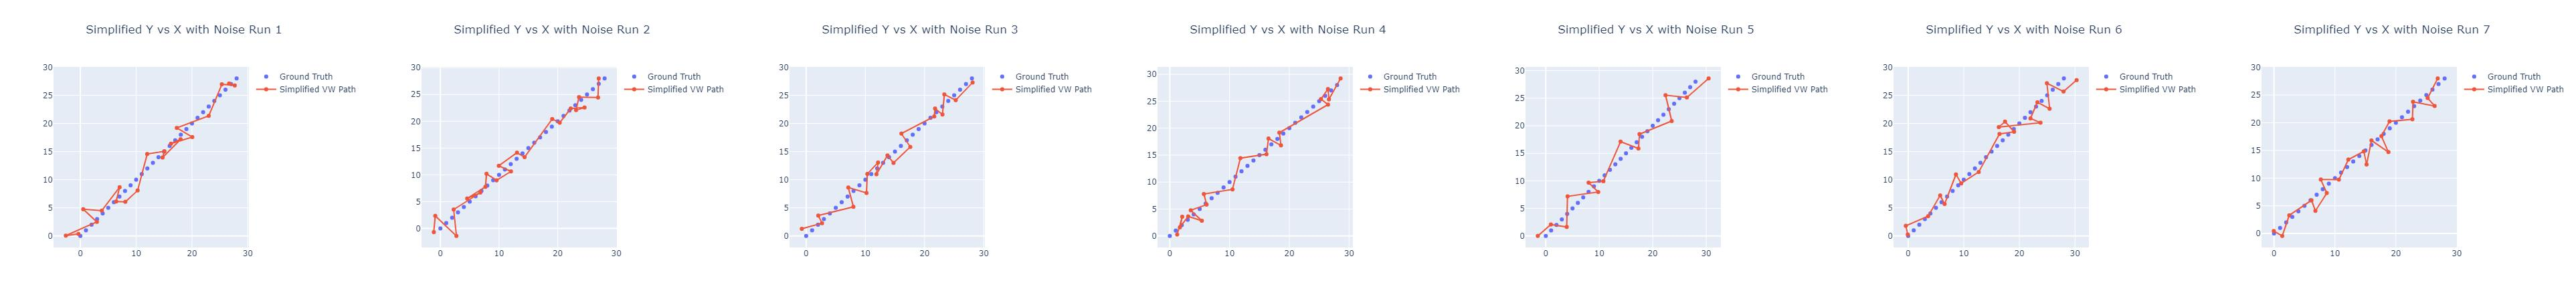


In [ ]:
#@title
simp_list = []
for i, simp_pdf in enumerate(simplified_df_list):
    spdf  = get_bearing_velocity_distance_simp_df(simp_pdf)
    fig = px.imshow(spdf.corr(), text_auto=True,title='Correlation for Run {0}'.format(i+1))
    fig.show()



#### Correlation RDP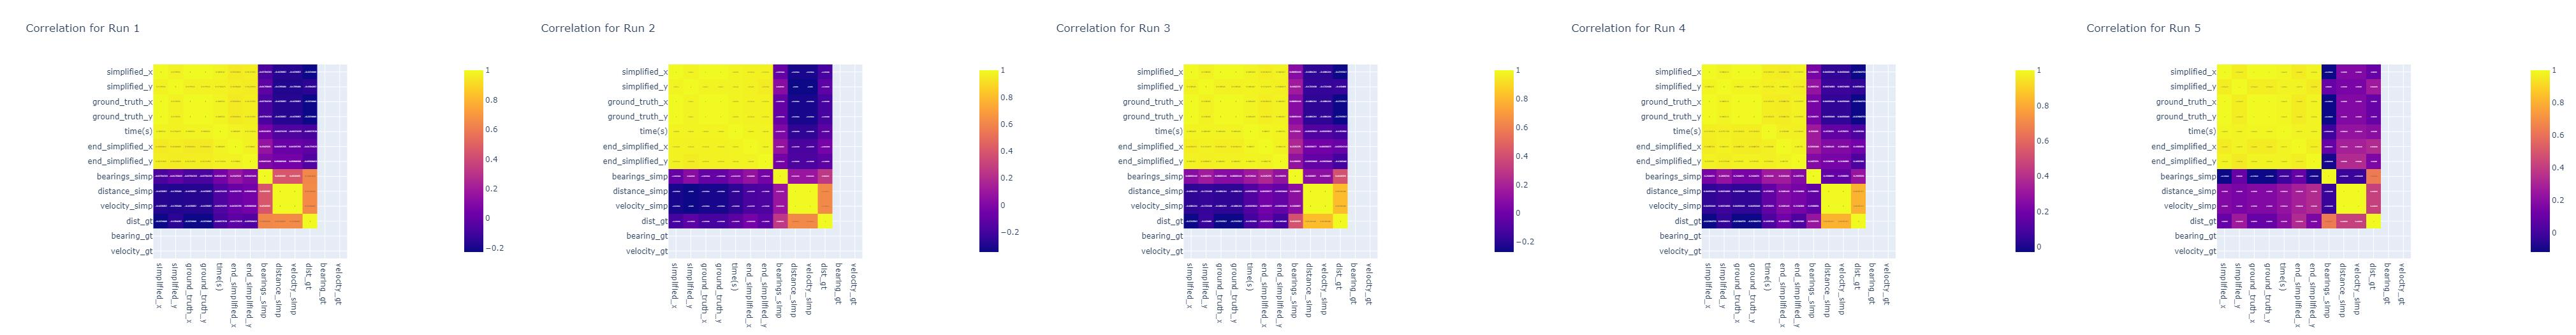

#### Mean Squared Error
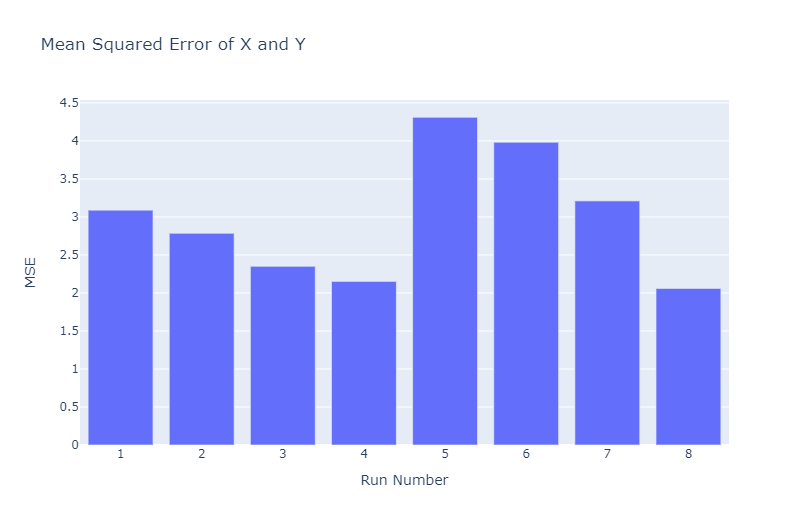

The Mean Squared Error Dropped by 1 (and I am not sure if that is significant or not). 

In [ ]:
#@title
#mse_list_x= []
mse_list_y = []
run_list = []
for i, pdf in enumerate(simplified_df_list):
    #mse_list_x.append(mean_squared_error(pdf['ground_truth_x'], pdf['simplified_x']))
    mse_list_y.append(mean_squared_error(pdf['ground_truth_y'], pdf['simplified_y']))
    run_list.append(i+1)


mse_df = pd.DataFrame({'run':run_list, 'mse_x':mse_list_x,'mse_y':mse_list_y})
mse_df
    
fig = go.Figure(data=[
    #go.Bar(name='Mean Squared Error X', x=mse_df['run'], y=mse_df['mse_x']),
    go.Bar(name='Mean Squared Error Y', x=mse_df['run'], y=mse_df['mse_y'])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_layout(title_text='Mean Squared Error of X and Y')
fig.update_xaxes(title='Run Number')
fig.update_yaxes(title='MSE')

fig.show()


#### Hasdorrf Distance of Simplified DataFrame

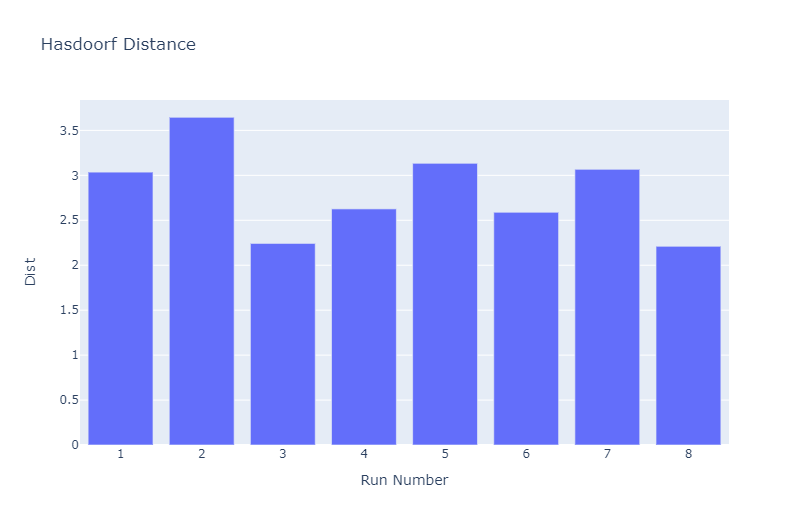

In [ ]:
#@title
simplified_df_list[0]

,simplified_x,simplified_y,simplified_points,ground_truth_x,ground_truth_y,time(s),start_point_gt,end_point_gt,end_simplified_x,end_simplified_y,end_simplified_points
0,-0.343838,0.365105,"(-0.3438382855883253, 0.36510507207035753)",-0.343838,-0.343838,0,"(-0.3438382855883253, -0.3438382855883253)","(-2.6097179182543377, -2.6097179182543377)",-2.609718,0.056349,"(-2.6097179182543377, 0.05634939053996668)"
1,-2.609718,0.056349,"(-2.6097179182543377, 0.05634939053996668)",-2.609718,-2.609718,3,"(-2.6097179182543377, -2.6097179182543377)","(2.95976507911477, 2.95976507911477)",2.959765,2.501511,"(2.95976507911477, 2.5015111974206388)"
2,2.959765,2.501511,"(2.95976507911477, 2.5015111974206388)",2.959765,2.959765,6,"(2.95976507911477, 2.95976507911477)","(0.5088741818753335, 0.5088741818753335)",0.508874,4.751629,"(0.5088741818753335, 4.751629436002567)"
3,0.508874,4.751629,"(0.5088741818753335, 4.751629436002567)",0.508874,0.508874,9,"(0.5088741818753335, 0.5088741818753335)","(3.8363446144901743, 3.8363446144901743)",3.836345,4.499061,"(3.8363446144901743, 4.499061132764423)"
4,3.836345,4.499061,"(3.8363446144901743, 4.499061132764423)",3.836345,3.836345,12,"(3.8363446144901743, 3.8363446144901743)","(7.036976210820473, 7.036976210820473)",7.036976,8.663828,"(7.036976210820473, 8.663827824957808)"
5,7.036976,8.663828,"(7.036976210820473, 8.663827824957808)",7.036976,7.036976,15,"(7.036976210820473, 7.036976210820473)","(6.4121405779259355, 6.4121405779259355)",6.412141,6.125273,"(6.4121405779259355, 6.12527265201326)"
6,6.412141,6.125273,"(6.4121405779259355, 6.12527265201326)",6.412141,6.412141,18,"(6.4121405779259355, 6.4121405779259355)","(8.056773486205895, 8.056773486205895)",8.056773,6.071921,"(8.056773486205895, 6.071920731584352)"
7,8.056773,6.071921,"(8.056773486205895, 6.071920731584352)",8.056773,8.056773,21,"(8.056773486205895, 8.056773486205895)","(10.262796315189359, 10.262796315189359)",10.262796,8.098198,"(10.262796315189359, 8.098198428813722)"
8,10.262796,8.098198,"(10.262796315189359, 8.098198428813722)",10.262796,10.262796,24,"(10.262796315189359, 10.262796315189359)","(11.971893296552663, 11.971893296552663)",11.971893,14.567112,"(11.971893296552663, 14.567111946179274)"
9,11.971893,14.567112,"(11.971893296552663, 14.567111946179274)",11.971893,11.971893,27,"(11.971893296552663, 11.971893296552663)","(15.063842616655402, 15.063842616655402)",15.063843,15.055265,"(15.063842616655402, 15.055265282166822)"


In [ ]:
#@title
run_list = []
hd_dist = []
for i, pdf in enumerate(simplified_df_list):
    u = np.array([*pdf['simplified_points']])
    v = np.array([*pdf['start_point_gt']])
    hdist = distance.directed_hausdorff(u,v)
    hd_dist.append(hdist)
    run_list.append(i+1)

hd_df = pd.DataFrame({'run':run_list,'hasdorff_distance':hd_dist})
hd_df['hasdorff_distance'] = hd_df['hasdorff_distance'].apply(pd.Series)[[0]]
hd_df

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:456: UserWarning:

you are shuffling a '_memoryviewslice' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.



,run,hasdorff_distance
0,1,3.036057
1,2,3.646190
2,3,2.242891
3,4,2.626819
4,5,3.134308
5,6,2.589598
6,7,3.067612
7,8,2.211065


In [ ]:
#@title
fig = go.Figure(data=[
    go.Bar(name='Hasdorrf Distance', x=hd_df['run'], y=hd_df['hasdorff_distance']),
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_layout(title_text='Hasdoorf Distance')
fig.update_xaxes(title='Run Number')
fig.update_yaxes(title='Dist')

fig.show()

## Short Comings in the Ramer-Douglas-Peucker algorithm:
---

The issue with the Ramer-Douglas-Peucker algorithm is the user set tolerance value. And if a trajectory has more than one movement behavior. This is an issue because, there is not a way to set the tolerance for one behavior and not the other without splitting a LineString and putting it back together again. Which brings us to the topic of Path Segmentation.




# Section 2: Ramer Douglas Peucker Algorithm on Real Data
---



## GeoLife Dataset
---
For this next part, we are going to be getting rid of the dataset that we were using before and using a sample GeoLife Dataset(s) (from Microsoft) that is provided by a .

The GeoLife Dataset tracks 186 individuals in China over  period of several months to a year. The sampling on the data is approximately every 2-5 seconds for 90% of the data. Thankfully, we are not dealing with all of that. We are dealing with an entity that is walking, then rides in a taxi. And also thankfully, we have labels. 


In [ ]:
walk_url  ='https://raw.githubusercontent.com/jbremz/Beijing-Trajectories-Project/master/Example%20Data/052/Trajectory/Labelled/20080520122500.csv'
taxi_url = 'https://raw.githubusercontent.com/jbremz/Beijing-Trajectories-Project/master/Example%20Data/052/Trajectory/Labelled/20080520141620.csv'

file_url_list = [walk_url, taxi_url]
traj_df =pd.concat([pd.read_csv(url) for url in file_url_list], ignore_index=True)
traj_df['point_geom'] = traj_df.apply(lambda x: Point(x['Lat'], x['Long']), axis=1)
tdf = skmob.TrajDataFrame(traj_df, latitude='Lat',longitude='Long', datetime='datetime')
tdf.plot_trajectory(zoom=12, weight=1, opacity=0.9)


/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.



### GeoLife Dataset Observations:
---
Looking at the walking portion of the dataset versus the other part. There are some differences that you can see. The first portion of the dataset is the walking portion, the second portion is when the entity is riding in a taxi. 

The differences are in the movements and for lack of a better word, how noisy the set of the movements when walking. Versus how noisy they are while driving. But lets look at each the walking trajectory dataframe and then look at the taxi driver trajectory dataframe.




#### Walking Trajectory DataFrame
---

In [ ]:
walk_traj_df = pd.read_csv(walk_url)
walk_traj_df['point_geom'] = walk_traj_df.apply(lambda x: Point(x['Lat'], x['Long']), axis=1)
tdf = skmob.TrajDataFrame(walk_traj_df, latitude='Lat',longitude='Long', datetime='datetime')
tdf.plot_trajectory(zoom=12, weight=1, opacity=0.9)


/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.



#### Taxi Trajectory DataFrame
---

In [ ]:
taxi_traj_df = pd.read_csv(taxi_url)
taxi_traj_df['point_geom'] = taxi_traj_df.apply(lambda x: Point(x['Lat'], x['Long']), axis=1)
tdf = skmob.TrajDataFrame(taxi_traj_df, latitude='Lat',longitude='Long', datetime='datetime')
tdf.plot_trajectory(zoom=12, weight=1, opacity=0.9)


/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.



### Getting Statistics out of the LineStrings
---
To get a better understanding of what we are dealing with, let's get some general statistics of the walking trajectory dataframe and the taxi_trajectory_dataframe. To do this, we will want to get the bearings, velocity, as well as distance for the Walking Trajectory DataFrame, as well as the Taxi Trajectory DataFrame.


In [ ]:
traj_df.rename({'Lat':'start_lat','Long':'start_long','point_geom':'start_point_geom','datetime':'start_datetime'},axis=1,inplace=True)

traj_df['start_datetime'] = pd.to_datetime(traj_df['start_datetime'])
traj_df[['end_lat','end_long','end_point_geom','end_datetime']] = traj_df[['start_lat','start_long','start_point_geom','start_datetime']].shift(-1)
traj_df.dropna(inplace=True)
traj_df['timestep'] = (traj_df['end_datetime'] - traj_df['start_datetime']) / pd.to_timedelta(1, unit='S')
traj_df['dist'] =  traj_df.apply(lambda x: x['start_point_geom'].distance(x['end_point_geom']),axis=1)
traj_df['bearing']  = traj_df.apply(lambda x: bearings(x['start_long'], x['start_lat'], x['end_long'], x['end_lat'], round_num=False),axis=1)
traj_df['velocity'] = traj_df['dist']/ traj_df['timestep']
traj_df.drop('Unnamed: 0',axis=1,inplace=True )
traj_df

,start_lat,start_long,-,Alt,dayNo,Date,Time,start_datetime,Transportation Mode,x,y,start_point_geom,end_lat,end_long,end_point_geom,end_datetime,timestep,dist,bearing,velocity
0,39.974821,116.311594,0,214,39588.517361,2008-05-20,12:25:00,2008-05-20 12:25:00,walk,-2197.271066,-184.823265,POINT (39.974821 116.311594),39.974820,116.311387,POINT (39.97482 116.311387),2008-05-20 12:25:02,2.0,0.000207,-90.361121,0.000104
1,39.974820,116.311387,0,216,39588.517384,2008-05-20,12:25:02,2008-05-20 12:25:02,walk,-2214.904891,-184.934431,POINT (39.97482 116.311387),39.974811,116.311213,POINT (39.974811 116.311213),2008-05-20 12:25:04,2.0,0.000174,-93.861334,0.000087
2,39.974811,116.311213,0,217,39588.517407,2008-05-20,12:25:04,2008-05-20 12:25:04,walk,-2229.727527,-185.934927,POINT (39.974811 116.311213),39.974827,116.311049,POINT (39.97482700000001 116.311049),2008-05-20 12:25:06,2.0,0.000165,-82.744658,0.000082
3,39.974827,116.311049,0,218,39588.517431,2008-05-20,12:25:06,2008-05-20 12:25:06,walk,-2243.698287,-184.156268,POINT (39.97482700000001 116.311049),39.974831,116.310880,POINT (39.974831 116.31088),2008-05-20 12:25:08,2.0,0.000169,-88.230880,0.000085
4,39.974831,116.310880,0,216,39588.517454,2008-05-20,12:25:08,2008-05-20 12:25:08,walk,-2258.094984,-183.711603,POINT (39.974831 116.31088),39.974818,116.310692,POINT (39.974818 116.310692),2008-05-20 12:25:10,2.0,0.000188,-95.156018,0.000094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,39.984775,116.352950,0,128,39588.599190,2008-05-20,14:22:50,2008-05-20 14:22:50,taxi,1325.745714,921.724542,POINT (39.984775 116.35295),39.984760,116.352966,POINT (39.98476 116.352966),2008-05-20 14:22:52,2.0,0.000022,140.740992,0.000011
725,39.984760,116.352966,0,127,39588.599213,2008-05-20,14:22:52,2008-05-20 14:22:52,taxi,1327.108715,920.057051,POINT (39.98476 116.352966),39.984736,116.352987,POINT (39.984736 116.352987),2008-05-20 14:22:54,2.0,0.000032,146.160568,0.000016
726,39.984736,116.352987,0,128,39588.599236,2008-05-20,14:22:54,2008-05-20 14:22:54,taxi,1328.897654,917.389065,POINT (39.984736 116.352987),39.984732,116.353009,POINT (39.984732 116.353009),2008-05-20 14:22:56,2.0,0.000022,103.349024,0.000011
727,39.984732,116.353009,0,127,39588.599259,2008-05-20,14:22:56,2008-05-20 14:22:56,taxi,1330.771780,916.944401,POINT (39.984732 116.353009),39.984712,116.352990,POINT (39.984712 116.35299),2008-05-20 14:22:58,2.0,0.000028,-143.948933,0.000014


#### Walking Trajectory DataFrame
----


In [ ]:
walk_df = traj_df.loc[traj_df['Transportation Mode'] == 'walk']
display(walk_df.describe())

,start_lat,start_long,-,Alt,dayNo,x,y,end_lat,end_long,timestep,dist,bearing,velocity
count,529.000000,529.000000,529.0,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000
mean,39.978984,116.307722,0.0,164.251418,39588.543507,-2527.098136,277.995098,39.979001,116.307707,12.627599,0.000060,1.183278,0.000019
std,0.003451,0.002864,0.0,113.065779,0.030544,244.018125,383.633065,0.003452,0.002866,150.420973,0.000228,90.150962,0.000025
min,39.974680,116.303003,0.0,-316.000000,39588.517361,-2929.117396,-200.497701,39.974680,116.303003,2.000000,0.000000,-177.562313,0.000000
25%,39.975650,116.304053,0.0,114.000000,39588.520417,-2839.670458,-92.666482,39.975657,116.304053,2.000000,0.000015,-69.550307,0.000007
50%,39.978608,116.309432,0.0,161.000000,39588.524421,-2381.446572,236.163076,39.978614,116.309408,2.000000,0.000026,-4.382109,0.000013
75%,39.983553,116.310035,0.0,244.000000,39588.588773,-2330.078473,785.879581,39.983564,116.310027,2.000000,0.000042,74.279639,0.000020
max,39.984105,116.311594,0.0,515.000000,39588.593704,-2197.271066,847.243265,39.984105,116.311387,3286.000000,0.003671,180.000000,0.000301


#### Taxi Trajectory DataFrame
---

In [ ]:
taxi_df = traj_df.loc[traj_df['Transportation Mode'] == 'taxi']
display(taxi_df.describe())

,start_lat,start_long,-,Alt,dayNo,x,y,end_lat,end_long,timestep,dist,bearing,velocity
count,200.000000,200.000000,200.0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,2.000000e+02,200.000000,2.000000e+02
mean,39.984813,116.337356,0.0,125.155000,39588.596979,-2.690412,925.965526,39.984818,116.337604,2.0,2.510310e-04,82.249137,1.255155e-04
std,0.000496,0.016646,0.0,8.111718,0.001340,1418.057819,55.131662,0.000490,0.016506,0.0,1.938485e-04,60.847297,9.692427e-05
min,39.983715,116.303353,0.0,111.000000,39588.594676,-2899.301750,803.888489,39.983723,116.303429,2.0,1.000000e-06,-171.287669,5.000000e-07
25%,39.984522,116.323898,0.0,121.000000,39588.595828,-1149.123317,893.543940,39.984537,116.324379,2.0,3.207785e-05,85.217515,1.603892e-05
50%,39.984995,116.344835,0.0,124.000000,39588.596979,634.491248,946.236663,39.984995,116.345103,2.0,2.806078e-04,88.192205,1.403039e-04
75%,39.985166,116.351826,0.0,128.000000,39588.598131,1230.016192,965.246062,39.985166,116.351827,2.0,4.525135e-04,100.867823,2.262567e-04
max,39.985365,116.353009,0.0,149.000000,39588.599282,1330.771780,987.312528,39.985365,116.353013,2.0,5.007285e-04,180.000000,2.503642e-04


## Applying the Ramer-Douglas Peucker Algorithm
---
We have a general idea of how the Visvalingam–Whyatt Algorithm works, but we need to apply the algorithm to real data and compare the LineStrings to their orignal to see the distance. 


### A Note on Tolerance
--- 
The tolerance level for the geospatial data, for lat and lon of ESPG 4326. The tolerance is the decimal degrees, so for a tolerance of 1 for lat and lon data, that would be a tolerance of approximately 111 km. A Tolerance of 0.1 is going to be a value of 11.1 km, a tolerance of 0.01 of 1.11 km. 
http://wiki.gis.com/wiki/index.php/Decimal_degrees


### Walking Data
---
As we can immediately see, the threshold value gets rid of all the data that between the first and the last point, that is no good at all. S


### Tolerance Threshold Definition
--- 
The tolerance level for the geospatial data, for lat and lon of ESPG 4326. The tolerance is the decimal degrees, so for a tolerance of 1 for lat and lon data, that would be a tolerance of approximately 111 km. A Tolerance of 0.1 is going to be a value of 11.1 km, a tolerance of 0.01 of 1.11 km. 
http://wiki.gis.com/wiki/index.php/Decimal_degrees



In [ ]:
threshold_list = [0.00001, 0.000001,0.001]

def plot_threshold(df, tolerence):
#for i, threshold in enumerate(threshold_list):

    
    simp_walk_df = pd.DataFrame(LineString(df['start_point_geom']).simplify(tolerence).coords, columns=['Lat','Long'])

    simp_walk_df['point_geom'] = simp_walk_df.apply(lambda x: Point(x['Lat'], x['Long']), axis=1)
    simp_walk_df['datetime'] = [datetime.datetime(2009, 12, 3, 1,0) for i in range(len(simp_walk_df))]

    tdf = skmob.TrajDataFrame(simp_walk_df, latitude='Lat',longitude='Long', datetime = 'datetime')
    return tdf.plot_trajectory(zoom=12, weight=1, opacity=0.9), tdf


#### Tolerance Value of 0.1

A little more definition



In [ ]:
plot_threshold(walk_df, .1)[0]

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.



##### Hasdoorf Distance

#### Tolerance of 0.0001

In [ ]:
plot_threshold(walk_df, 0.0001)[0]

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.



##### Hasdoorf Distance

#### Tolerance of 0.00001


In [ ]:
plot_threshold(walk_df, .00001)[0]

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.



##### Hasdorrf Distance

In [ ]:
plot_threshold(walk_df, .00001)[0]

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.



## Tolerance Conclusion

As you an see, with every decimal place it effects the trajector that is taken. For the Walking Dataset, the tolerance should be set somewhere between 0.001 and 0.0001.


### Taxi Trajectory Data

Tolerance Level 0.1

In [ ]:
taxi_df = taxi_df.dropna().reset_index(drop=True)
plot_threshold(taxi_df, .1)[0]

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.



In [ ]:
taxi_df = taxi_df.dropna().reset_index(drop=True)
plot_threshold(taxi_df, .01)[0]

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.



In [ ]:
taxi_df = taxi_df.dropna().reset_index(drop=True)
plot_threshold(taxi_df, .001)[0]

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.



### Taxi Threshold

The taxi threshold should be somewhere between 0.1 and 0.01. However that is not the same threshold for the walking portion of the path dataframe. So what do we do about that?

# Part 3: Path Segmentation
---

Path segmentation is a subfield of ecology that classifies movement data into seperate clusters. For this part of the paper, we are going to be creating a model that can predict the cluster the that path segment should be in, and we will have preset Threshold that should be applied to each one.

{Walking: Tolerance=0.0001, Driving/Taxi: Tolerance=0.001, Plane: Tolerance=.01}



## A Light Literature Review 
---

> Some researchers have used Convulational Neural Networks by treating each of the trajectory on a map as an image and classifying the type of the total trajectory. This might be something to keep as we are moving forward, but I don't think this is quite what we are looking for.
[https://github.com/jbremz/Beijing-Trajectories-Project/blob/master/Classification/Classification%20Notes.ipynb]

>  The literature on Path Segmentation (or lack thereof) is more interesting. Path Segmentation is the process of breaking down each trajectory into pieces, turning those pieces into different variables (Bearing, Velocity, Displacement, Straightness) and so forth.  [https://movementecologyjournal.biomedcentral.com/articles/10.1186/s40462-016-0086-5]

>
> There is continuing research on the type of algorithms that you are using, and the result is if you have data that is prelabeled available (like I do) then go with building a classifier. If you do not, probably go with an unsupervised algorithm such as DBSCAN or KMeans. [https://www.sciencedirect.com/science/article/abs/pii/S0021929004002258?via%3Dihub
Data Resources]

>
> There is a great need for algorithms like this since, the errors from sensor noise might be greater than the step size itsef [https://besjournals.onlinelibrary.wiley.com/doi/10.1111/1365-2656.13610]





## Feature Selection
---
> We are going to need bearings, the velocity, the step length, and time-lag as some basic metrics [https://movementecologyjournal.biomedcentral.com/articles/10.1186/s40462-016-0086-5/tables/1]. 

> We are also going to need to indicate the distance it takes before a major change in the same direction. The change of end point is defined as a z_score  represetned as $z$ being greater than 1. Where the cummaltive sum is defined as $y[i]$.

> We will not be including the start point or the end point of the data.



### Training Data

We will be using the labeled dataset from [https://github.com/jbremz/Beijing-Trajectories-Project/tree/master/Example%20Data/028/Trajectory] to build a classifier. 

### Model Selection Options:
- Random Forecast Classifier
- 


### More Functions

In [ ]:
def transform_geo_life_df(df):
    """
    Args:
       ts_list (int): A list of timestamps 
       pt_list (tuple): 

    Returns:
        pd.DataFrame
    """
    df.rename({'Lat':'start_lat','Long':'start_long','point_geom':'start_point_geom','datetime':'start_datetime'},axis=1,inplace=True)

    df['start_datetime'] = pd.to_datetime(df['start_datetime'])
    df[['end_lat','end_long','end_point_geom','end_datetime']] = df[['start_lat','start_long','start_point_geom','start_datetime']].shift(-1)
    df.dropna(inplace=True)
    df['timestep'] = (df['end_datetime'] - df['start_datetime']) / pd.to_timedelta(1, unit='S')
    df['dist'] =  df.apply(lambda x: x['start_point_geom'].distance(x['end_point_geom']),axis=1)
    df['bearing']  = df.apply(lambda x: bearings(x['start_long'], x['start_lat'], x['end_long'], x['end_lat'], round_num=False),axis=1)
    df['velocity'] = df['dist']/ df['timestep']
    df.drop('Unnamed: 0',axis=1,inplace=True )

    return df

def reduce_df(df):

    df = (df.loc[(df['Transportation Mode']=='walk') | 
             (df['Transportation Mode']=='subway')| 
             (df['Transportation Mode']=='taxi') |
             (df['Transportation Mode']=='bike')]).reset_index(drop=True)
    df['point_geom'] = df.apply(lambda x: Point(x['Long'], x['Lat']),axis=1)
    return df


def get_zscore(df):
    pass

In [ ]:
files = ['Example Data/052/Trajectory/Labelled/20080520122500.csv', 'Example Data/052/Trajectory/Labelled/20080520094035.csv', 'Example Data/052/Trajectory/Labelled/20080521123501.csv', 'Example Data/052/Trajectory/Labelled/20080521072601.csv', 'Example Data/052/Trajectory/Labelled/20080523044542.csv', 'Example Data/052/Trajectory/Labelled/20080520141620.csv', 'Example Data/052/Trajectory/Labelled/20080520121510.csv', 'Example Data/052/Trajectory/Labelled/20080521101353.csv', 'Example Data/052/Trajectory/Labelled/20080521121543.csv', 'Example Data/052/Trajectory/Labelled/20080522100008.csv', 'Example Data/052/Trajectory/Labelled/20080521135027.csv', 'Example Data/052/Trajectory/Labelled/20080521033532.csv', 'Example Data/052/Trajectory/Labelled/20080523064456.csv', 'Example Data/052/Trajectory/Labelled/20080521032516.csv', 'Example Data/052/Trajectory/Labelled/20080523051016.csv', 'Example Data/052/Trajectory/Labelled/20080525053129.csv', 'Example Data/052/Trajectory/Labelled/20080522091050.csv', 'Example Data/052/Trajectory/Labelled/20080525093457.csv', 'Example Data/052/Trajectory/Labelled/20080525125901.csv', 'Example Data/052/Trajectory/Labelled/20080521123803.csv', 'Example Data/052/Trajectory/Labelled/20080521103601.csv', 'Example Data/052/Trajectory/Labelled/20080526124007.csv', 'Example Data/052/Trajectory/Labelled/20080527085723.csv', 'Example Data/052/Trajectory/Labelled/20080529064353.csv', 'Example Data/052/Trajectory/Labelled/20080528113420.csv', 'Example Data/052/Trajectory/Labelled/20080528095006.csv', 'Example Data/052/Trajectory/Labelled/20080528092335.csv', 'Example Data/052/Trajectory/Labelled/20080522090054.csv', 'Example Data/052/Trajectory/Labelled/20080525164457.csv', 'Example Data/052/Trajectory/Labelled/20080525112839.csv', 'Example Data/052/Trajectory/Labelled/20080525090257.csv', 'Example Data/052/Trajectory/Labelled/20080529073001.csv', 'Example Data/052/Trajectory/Labelled/20080529065241.csv', 'Example Data/052/Trajectory/Labelled/20080530100805.csv', 'Example Data/052/Trajectory/Labelled/20080525105149.csv', 'Example Data/052/Trajectory/Labelled/20080531071234.csv', 'Example Data/052/Trajectory/Labelled/20080531110116.csv', 'Example Data/052/Trajectory/Labelled/20080527101527.csv', 'Example Data/052/Trajectory/Labelled/20080531035848.csv', 'Example Data/052/Trajectory/Labelled/20080602034606.csv', 'Example Data/052/Trajectory/Labelled/20080601094724.csv', 'Example Data/052/Trajectory/Labelled/20080525054105.csv', 'Example Data/052/Trajectory/Labelled/20080527074452.csv', 'Example Data/052/Trajectory/Labelled/20080601133352.csv', 'Example Data/052/Trajectory/Labelled/20080531100404.csv', 'Example Data/052/Trajectory/Labelled/20080602061818.csv', 'Example Data/052/Trajectory/Labelled/20080602040644.csv', 'Example Data/052/Trajectory/Labelled/20080528114522.csv', 'Example Data/052/Trajectory/Labelled/20080603092527.csv', 'Example Data/052/Trajectory/Labelled/20080603035158.csv', 'Example Data/052/Trajectory/Labelled/20080603130343.csv', 'Example Data/052/Trajectory/Labelled/20080603002235.csv', 'Example Data/052/Trajectory/Labelled/20080530101103.csv', 'Example Data/052/Trajectory/Labelled/20080603134625.csv', 'Example Data/052/Trajectory/Labelled/20080606035050.csv', 'Example Data/052/Trajectory/Labelled/20080606084938.csv', 'Example Data/052/Trajectory/Labelled/20080531034238.csv', 'Example Data/052/Trajectory/Labelled/20080606131532.csv', 'Example Data/052/Trajectory/Labelled/20080607110443.csv', 'Example Data/052/Trajectory/Labelled/20080607093313.csv', 'Example Data/052/Trajectory/Labelled/20080607114953.csv', 'Example Data/052/Trajectory/Labelled/20080531103800.csv', 'Example Data/052/Trajectory/Labelled/20080531125826.csv', 'Example Data/052/Trajectory/Labelled/20080605084023.csv', 'Example Data/052/Trajectory/Labelled/20080609034805.csv', 'Example Data/052/Trajectory/Labelled/20080606091550.csv', 'Example Data/052/Trajectory/Labelled/20080531092900.csv', 'Example Data/052/Trajectory/Labelled/20080604121559.csv', 'Example Data/052/Trajectory/Labelled/20080609074631.csv', 'Example Data/052/Trajectory/Labelled/20080607124455.csv', 'Example Data/052/Trajectory/Labelled/20080609092059.csv', 'Example Data/052/Trajectory/Labelled/20080609103659.csv', 'Example Data/052/Trajectory/Labelled/20080612085237.csv', 'Example Data/052/Trajectory/Labelled/20080610111332.csv', 'Example Data/052/Trajectory/Labelled/20080612041404.csv', 'Example Data/052/Trajectory/Labelled/20080609122745.csv', 'Example Data/052/Trajectory/Labelled/20080610113000.csv', 'Example Data/052/Trajectory/Labelled/20080612222001.csv', 'Example Data/052/Trajectory/Labelled/20080613051431.csv', 'Example Data/052/Trajectory/Labelled/20080614085905.csv', 'Example Data/052/Trajectory/Labelled/20080615065036.csv', 'Example Data/052/Trajectory/Labelled/20080614130257.csv', 'Example Data/052/Trajectory/Labelled/20080615142801.csv', 'Example Data/052/Trajectory/Labelled/20080609100849.csv', 'Example Data/052/Trajectory/Labelled/20080616050730.csv', 'Example Data/052/Trajectory/Labelled/20080613015306.csv', 'Example Data/052/Trajectory/Labelled/20080616065908.csv', 'Example Data/052/Trajectory/Labelled/20080610133012.csv', 'Example Data/052/Trajectory/Labelled/20080617042723.csv', 'Example Data/052/Trajectory/Labelled/20080620014602.csv', 'Example Data/052/Trajectory/Labelled/20080617072308.csv', 'Example Data/052/Trajectory/Labelled/20080620013137.csv', 'Example Data/052/Trajectory/Labelled/20080615071001.csv', 'Example Data/052/Trajectory/Labelled/20080616051910.csv', 'Example Data/052/Trajectory/Labelled/20080620041607.csv', 'Example Data/052/Trajectory/Labelled/20080621101507.csv', 'Example Data/052/Trajectory/Labelled/20080621013806.csv', 'Example Data/052/Trajectory/Labelled/20080620100636.csv', 'Example Data/052/Trajectory/Labelled/20080621124503.csv', 'Example Data/052/Trajectory/Labelled/20080620021022.csv', 'Example Data/052/Trajectory/Labelled/20080621160803.csv', 'Example Data/052/Trajectory/Labelled/20080625063822.csv', 'Example Data/052/Trajectory/Labelled/20080620103926.csv', 'Example Data/052/Trajectory/Labelled/20080625052637.csv', 'Example Data/052/Trajectory/Labelled/20080625053847.csv', 'Example Data/052/Trajectory/Labelled/20080625064812.csv', 'Example Data/052/Trajectory/Labelled/20080625124823.csv', 'Example Data/052/Trajectory/Labelled/20080626204306.csv', 'Example Data/052/Trajectory/Labelled/20080626205641.csv', 'Example Data/052/Trajectory/Labelled/20080626222331.csv', 'Example Data/052/Trajectory/Labelled/20080620111241.csv', 'Example Data/052/Trajectory/Labelled/20080626234501.csv', 'Example Data/052/Trajectory/Labelled/20080627015826.csv', 'Example Data/052/Trajectory/Labelled/20080627030836.csv', 'Example Data/052/Trajectory/Labelled/20080627033641.csv', 'Example Data/052/Trajectory/Labelled/20080628232655.csv', 'Example Data/052/Trajectory/Labelled/20080629022249.csv', 'Example Data/052/Trajectory/Labelled/20080629042317.csv', 'Example Data/052/Trajectory/Labelled/20080620043647.csv', 'Example Data/052/Trajectory/Labelled/20080629090257.csv', 'Example Data/052/Trajectory/Labelled/20080629091017.csv', 'Example Data/052/Trajectory/Labelled/20080702094938.csv', 'Example Data/052/Trajectory/Labelled/20080629083757.csv', 'Example Data/052/Trajectory/Labelled/20080703063902.csv', 'Example Data/052/Trajectory/Labelled/20080703114557.csv', 'Example Data/052/Trajectory/Labelled/20080703150207.csv', 'Example Data/052/Trajectory/Labelled/20080629061612.csv', 'Example Data/052/Trajectory/Labelled/20080706090206.csv', 'Example Data/052/Trajectory/Labelled/20080706091651.csv', 'Example Data/052/Trajectory/Labelled/20080706093531.csv', 'Example Data/052/Trajectory/Labelled/20080706110356.csv', 'Example Data/052/Trajectory/Labelled/20080706111941.csv', 'Example Data/052/Trajectory/Labelled/20080707064053.csv', 'Example Data/052/Trajectory/Labelled/20080629064217.csv', 'Example Data/052/Trajectory/Labelled/20080626213001.csv', 'Example Data/052/Trajectory/Labelled/20080708125325.csv', 'Example Data/052/Trajectory/Labelled/20080709020511.csv', 'Example Data/052/Trajectory/Labelled/20080701091144.csv', 'Example Data/052/Trajectory/Labelled/20080709023701.csv', 'Example Data/052/Trajectory/Labelled/20080629054852.csv', 'Example Data/052/Trajectory/Labelled/20080702100023.csv', 'Example Data/052/Trajectory/Labelled/20080709095902.csv', 'Example Data/052/Trajectory/Labelled/20080628235945.csv', 'Example Data/052/Trajectory/Labelled/20080709035556.csv', 'Example Data/052/Trajectory/Labelled/20080702123713.csv', 'Example Data/052/Trajectory/Labelled/20080709154407.csv', 'Example Data/052/Trajectory/Labelled/20080709130937.csv', 'Example Data/052/Trajectory/Labelled/20080709100807.csv', 'Example Data/052/Trajectory/Labelled/20080709143247.csv', 'Example Data/052/Trajectory/Labelled/20080709042706.csv', 'Example Data/052/Trajectory/Labelled/20080709212205.csv', 'Example Data/052/Trajectory/Labelled/20080709185447.csv', 'Example Data/052/Trajectory/Labelled/20080709215435.csv', 'Example Data/052/Trajectory/Labelled/20080709220540.csv', 'Example Data/052/Trajectory/Labelled/20080709235850.csv', 'Example Data/052/Trajectory/Labelled/20080709232155.csv', 'Example Data/052/Trajectory/Labelled/20080710091108.csv', 'Example Data/052/Trajectory/Labelled/20080709231635.csv', 'Example Data/052/Trajectory/Labelled/20080711021006.csv', 'Example Data/052/Trajectory/Labelled/20080711015836.csv', 'Example Data/052/Trajectory/Labelled/20080711041551.csv', 'Example Data/052/Trajectory/Labelled/20080711023601.csv', 'Example Data/052/Trajectory/Labelled/20080711044111.csv', 'Example Data/052/Trajectory/Labelled/20080711051401.csv', 'Example Data/052/Trajectory/Labelled/20080711063551.csv', 'Example Data/052/Trajectory/Labelled/20080711102911.csv', 'Example Data/052/Trajectory/Labelled/20080711104216.csv', 'Example Data/052/Trajectory/Labelled/20080703064907.csv', 'Example Data/052/Trajectory/Labelled/20080710093913.csv', 'Example Data/052/Trajectory/Labelled/20080711070521.csv', 'Example Data/052/Trajectory/Labelled/20080711093901.csv', 'Example Data/052/Trajectory/Labelled/20080709212835.csv', 'Example Data/052/Trajectory/Labelled/20080716083551.csv', 'Example Data/052/Trajectory/Labelled/20080717032214.csv', 'Example Data/052/Trajectory/Labelled/20080715104708.csv', 'Example Data/052/Trajectory/Labelled/20080717015934.csv', 'Example Data/052/Trajectory/Labelled/20080717083531.csv', 'Example Data/052/Trajectory/Labelled/20080717093456.csv', 'Example Data/052/Trajectory/Labelled/20080711132356.csv', 'Example Data/052/Trajectory/Labelled/20080717011859.csv', 'Example Data/052/Trajectory/Labelled/20080717121106.csv', 'Example Data/052/Trajectory/Labelled/20080710133933.csv', 'Example Data/052/Trajectory/Labelled/20080717100356.csv', 'Example Data/052/Trajectory/Labelled/20080718045225.csv', 'Example Data/052/Trajectory/Labelled/20080719044536.csv', 'Example Data/052/Trajectory/Labelled/20080718052050.csv', 'Example Data/052/Trajectory/Labelled/20080719053451.csv', 'Example Data/052/Trajectory/Labelled/20080719055241.csv', 'Example Data/052/Trajectory/Labelled/20080718060025.csv', 'Example Data/052/Trajectory/Labelled/20080719093121.csv', 'Example Data/052/Trajectory/Labelled/20080711105531.csv', 'Example Data/052/Trajectory/Labelled/20080719162501.csv', 'Example Data/052/Trajectory/Labelled/20080720055433.csv', 'Example Data/052/Trajectory/Labelled/20080720093628.csv', 'Example Data/052/Trajectory/Labelled/20080720074038.csv', 'Example Data/052/Trajectory/Labelled/20080717073456.csv', 'Example Data/052/Trajectory/Labelled/20080720090358.csv', 'Example Data/052/Trajectory/Labelled/20080720094213.csv', 'Example Data/052/Trajectory/Labelled/20080720044908.csv', 'Example Data/052/Trajectory/Labelled/20080721041611.csv', 'Example Data/052/Trajectory/Labelled/20080720100653.csv', 'Example Data/052/Trajectory/Labelled/20080721045651.csv', 'Example Data/052/Trajectory/Labelled/20080721071636.csv', 'Example Data/052/Trajectory/Labelled/20080721123216.csv', 'Example Data/052/Trajectory/Labelled/20080721093941.csv', 'Example Data/052/Trajectory/Labelled/20080722041604.csv', 'Example Data/052/Trajectory/Labelled/20080719052941.csv', 'Example Data/052/Trajectory/Labelled/20080722045349.csv', 'Example Data/052/Trajectory/Labelled/20080722073939.csv', 'Example Data/052/Trajectory/Labelled/20080722075859.csv', 'Example Data/052/Trajectory/Labelled/20080721074941.csv', 'Example Data/052/Trajectory/Labelled/20080722091929.csv', 'Example Data/052/Trajectory/Labelled/20080722085604.csv', 'Example Data/052/Trajectory/Labelled/20080723120252.csv', 'Example Data/052/Trajectory/Labelled/20080723122637.csv', 'Example Data/052/Trajectory/Labelled/20080724021720.csv', 'Example Data/052/Trajectory/Labelled/20080724050145.csv', 'Example Data/052/Trajectory/Labelled/20080724064210.csv', 'Example Data/052/Trajectory/Labelled/20080724050915.csv', 'Example Data/052/Trajectory/Labelled/20080724062855.csv', 'Example Data/052/Trajectory/Labelled/20080723102412.csv', 'Example Data/052/Trajectory/Labelled/20080725002826.csv', 'Example Data/052/Trajectory/Labelled/20080724013535.csv', 'Example Data/052/Trajectory/Labelled/20080725072754.csv', 'Example Data/052/Trajectory/Labelled/20080725012931.csv', 'Example Data/052/Trajectory/Labelled/20080725071224.csv', 'Example Data/052/Trajectory/Labelled/20080723082932.csv', 'Example Data/052/Trajectory/Labelled/20080727033556.csv', 'Example Data/052/Trajectory/Labelled/20080726091506.csv', 'Example Data/052/Trajectory/Labelled/20080727040606.csv', 'Example Data/052/Trajectory/Labelled/20080726122906.csv', 'Example Data/052/Trajectory/Labelled/20080725080444.csv', 'Example Data/052/Trajectory/Labelled/20080726083936.csv', 'Example Data/052/Trajectory/Labelled/20080727092302.csv', 'Example Data/052/Trajectory/Labelled/20080727165404.csv', 'Example Data/052/Trajectory/Labelled/20080729111821.csv', 'Example Data/052/Trajectory/Labelled/20080729131811.csv', 'Example Data/052/Trajectory/Labelled/20080730092319.csv', 'Example Data/052/Trajectory/Labelled/20080730095229.csv', 'Example Data/052/Trajectory/Labelled/20080727112624.csv', 'Example Data/052/Trajectory/Labelled/20080730120344.csv', 'Example Data/052/Trajectory/Labelled/20080729104926.csv', 'Example Data/052/Trajectory/Labelled/20080730132704.csv', 'Example Data/052/Trajectory/Labelled/20080730120929.csv', 'Example Data/052/Trajectory/Labelled/20080730135539.csv', 'Example Data/052/Trajectory/Labelled/20080731001522.csv', 'Example Data/052/Trajectory/Labelled/20080731035307.csv', 'Example Data/052/Trajectory/Labelled/20080731073512.csv', 'Example Data/052/Trajectory/Labelled/20080725082034.csv', 'Example Data/052/Trajectory/Labelled/20080822094932.csv', 'Example Data/052/Trajectory/Labelled/20080818112052.csv', 'Example Data/052/Trajectory/Labelled/20080822091106.csv', 'Example Data/052/Trajectory/Labelled/20080902072351.csv', 'Example Data/052/Trajectory/Labelled/20080902075058.csv', 'Example Data/052/Trajectory/Labelled/20081002125022.csv', 'Example Data/052/Trajectory/Labelled/20081002105157.csv', 'Example Data/052/Trajectory/Labelled/20080902055635.csv', 'Example Data/052/Trajectory/Labelled/20081002143402.csv', 'Example Data/052/Trajectory/Labelled/20081003042435.csv', 'Example Data/052/Trajectory/Labelled/20081003044725.csv', 'Example Data/052/Trajectory/Labelled/20081003065815.csv', 'Example Data/052/Trajectory/Labelled/20081001224837.csv', 'Example Data/052/Trajectory/Labelled/20081002133447.csv', 'Example Data/052/Trajectory/Labelled/20081005101320.csv', 'Example Data/052/Trajectory/Labelled/20081006135632.csv', 'Example Data/052/Trajectory/Labelled/20080729125201.csv', 'Example Data/052/Trajectory/Labelled/20081006032437.csv', 'Example Data/052/Trajectory/Labelled/20081007001045.csv', 'Example Data/052/Trajectory/Labelled/20081007002200.csv', 'Example Data/052/Trajectory/Labelled/20081007000310.csv', 'Example Data/052/Trajectory/Labelled/20081007020218.csv', 'Example Data/052/Trajectory/Labelled/20081005135127.csv', 'Example Data/052/Trajectory/Labelled/20081007021543.csv', 'Example Data/052/Trajectory/Labelled/20080731022432.csv', 'Example Data/052/Trajectory/Labelled/20081007023048.csv', 'Example Data/052/Trajectory/Labelled/20081008035138.csv', 'Example Data/052/Trajectory/Labelled/20081007111938.csv', 'Example Data/052/Trajectory/Labelled/20081005094923.csv', 'Example Data/052/Trajectory/Labelled/20081002062627.csv', 'Example Data/052/Trajectory/Labelled/20081010011727.csv', 'Example Data/052/Trajectory/Labelled/20081010045331.csv', 'Example Data/052/Trajectory/Labelled/20081008041438.csv', 'Example Data/052/Trajectory/Labelled/20081010130637.csv', 'Example Data/052/Trajectory/Labelled/20081010120707.csv', 'Example Data/052/Trajectory/Labelled/20081010013057.csv', 'Example Data/052/Trajectory/Labelled/20081008063829.csv']

base = 'https://raw.githubusercontent.com/jbremz/Beijing-Trajectories-Project/master/Example%20Data/052/Trajectory/Labelled/'

file_list = [base + f.rsplit('/',1)[1] for f in files]
print(file_list)

['https://raw.githubusercontent.com/jbremz/Beijing-Trajectories-Project/master/Example%20Data/052/Trajectory/Labelled/20080520122500.csv', 'https://raw.githubusercontent.com/jbremz/Beijing-Trajectories-Project/master/Example%20Data/052/Trajectory/Labelled/20080520094035.csv', 'https://raw.githubusercontent.com/jbremz/Beijing-Trajectories-Project/master/Example%20Data/052/Trajectory/Labelled/20080521123501.csv', 'https://raw.githubusercontent.com/jbremz/Beijing-Trajectories-Project/master/Example%20Data/052/Trajectory/Labelled/20080521072601.csv', 'https://raw.githubusercontent.com/jbremz/Beijing-Trajectories-Project/master/Example%20Data/052/Trajectory/Labelled/20080523044542.csv', 'https://raw.githubusercontent.com/jbremz/Beijing-Trajectories-Project/master/Example%20Data/052/Trajectory/Labelled/20080520141620.csv', 'https://raw.githubusercontent.com/jbremz/Beijing-Trajectories-Project/master/Example%20Data/052/Trajectory/Labelled/20080520121510.csv', 'https://raw.githubusercontent.co

In [ ]:
# You

#random.choices(file_list, k=450)	
df_list = []
run_list = []
for i, f in enumerate(file_list[:120]):
    try:
        df = pd.read_csv(f)
        walk_train_bike_df = reduce_df(df)
        transformed_df = transform_geo_life_df(walk_train_bike_df)
        transformed_df['run_number'] = i+1
        df_list.append(transformed_df)

        run_list.append(i+1)
    except:
        pass


df = pd.concat(df_list, ignore_index=True)
df 

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,start_lat,start_long,-,Alt,dayNo,Date,Time,start_datetime,Transportation Mode,x,...,start_point_geom,end_lat,end_long,end_point_geom,end_datetime,timestep,dist,bearing,velocity,run_number
0,39.974821,116.311594,0,214,39588.517361,2008-05-20,12:25:00,2008-05-20 12:25:00,walk,-2197.271066,...,POINT (116.311594 39.974821),39.974820,116.311387,POINT (116.311387 39.97482),2008-05-20 12:25:02,2.0,0.000207,-90.361121,0.000104,1
1,39.974820,116.311387,0,216,39588.517384,2008-05-20,12:25:02,2008-05-20 12:25:02,walk,-2214.904891,...,POINT (116.311387 39.97482),39.974811,116.311213,POINT (116.311213 39.974811),2008-05-20 12:25:04,2.0,0.000174,-93.861334,0.000087,1
2,39.974811,116.311213,0,217,39588.517407,2008-05-20,12:25:04,2008-05-20 12:25:04,walk,-2229.727527,...,POINT (116.311213 39.974811),39.974827,116.311049,POINT (116.311049 39.97482700000001),2008-05-20 12:25:06,2.0,0.000165,-82.744658,0.000082,1
3,39.974827,116.311049,0,218,39588.517431,2008-05-20,12:25:06,2008-05-20 12:25:06,walk,-2243.698287,...,POINT (116.311049 39.97482700000001),39.974831,116.310880,POINT (116.31088 39.974831),2008-05-20 12:25:08,2.0,0.000169,-88.230880,0.000085,1
4,39.974831,116.310880,0,216,39588.517454,2008-05-20,12:25:08,2008-05-20 12:25:08,walk,-2258.094984,...,POINT (116.31088 39.974831),39.974818,116.310692,POINT (116.310692 39.974818),2008-05-20 12:25:10,2.0,0.000188,-95.156018,0.000094,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30100,39.987055,116.408971,0,170,39628.381620,2008-06-29,09:09:32,2008-06-29 09:09:32,walk,6098.037929,...,POINT (116.408971 39.987055),39.987469,116.408977,POINT (116.408977 39.987469),2008-06-29 09:09:57,25.0,0.000414,0.636194,0.000017,120
30101,39.987469,116.408977,0,131,39628.381910,2008-06-29,09:09:57,2008-06-29 09:09:57,walk,6098.549055,...,POINT (116.408977 39.987469),39.987428,116.408985,POINT (116.40898500000002 39.987428),2008-06-29 09:10:02,5.0,0.000042,171.497276,0.000008,120
30102,39.987428,116.408985,0,203,39628.381968,2008-06-29,09:10:02,2008-06-29 09:10:02,walk,6099.230555,...,POINT (116.40898500000002 39.987428),39.987473,116.409041,POINT (116.409041 39.987473),2008-06-29 09:10:07,5.0,0.000072,43.635651,0.000014,120
30103,39.987473,116.409041,0,187,39628.382025,2008-06-29,09:10:07,2008-06-29 09:10:07,walk,6104.001058,...,POINT (116.409041 39.987473),39.987491,116.409012,POINT (116.409012 39.987491),2008-06-29 09:10:12,5.0,0.000034,-50.988910,0.000007,120


In [ ]:
print(len(file_list))

286


## Walking Vs Taxi

*   List item
*   List item

walking, taxi, and bike


In [ ]:
df['Transportation Mode'].unique()

array(['walk', 'taxi', 'subway'], dtype=object)

In [ ]:
df = df[['Transportation Mode','timestep','dist','bearing','velocity', 'start_lat','end_lat','start_long','end_long','run_number']]
df['change_lat'] = df['start_lat'] - df['end_lat']
df['change_long'] = df['start_long'] - df['end_long']
df.dropna(inplace=True,axis=1)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

,Transportation Mode,timestep,dist,bearing,velocity,start_lat,end_lat,start_long,end_long,run_number,change_lat,change_long
0,walk,2.0,0.000207,-90.361121,0.000104,39.974821,39.974820,116.311594,116.311387,1,1.000000e-06,0.000207
1,walk,2.0,0.000174,-93.861334,0.000087,39.974820,39.974811,116.311387,116.311213,1,9.000000e-06,0.000174
2,walk,2.0,0.000165,-82.744658,0.000082,39.974811,39.974827,116.311213,116.311049,1,-1.600000e-05,0.000164
3,walk,2.0,0.000169,-88.230880,0.000085,39.974827,39.974831,116.311049,116.310880,1,-4.000000e-06,0.000169
4,walk,2.0,0.000188,-95.156018,0.000094,39.974831,39.974818,116.310880,116.310692,1,1.300000e-05,0.000188
...,...,...,...,...,...,...,...,...,...,...,...,...
30100,walk,25.0,0.000414,0.636194,0.000017,39.987055,39.987469,116.408971,116.408977,120,-4.140000e-04,-0.000006
30101,walk,5.0,0.000042,171.497276,0.000008,39.987469,39.987428,116.408977,116.408985,120,4.100000e-05,-0.000008
30102,walk,5.0,0.000072,43.635651,0.000014,39.987428,39.987473,116.408985,116.409041,120,-4.500000e-05,-0.000056
30103,walk,5.0,0.000034,-50.988910,0.000007,39.987473,39.987491,116.409041,116.409012,120,-1.800000e-05,0.000029


In [ ]:
df['zscore'] =zscore(df['bearing'])
df['zscore'] = df['zscore'].apply(abs)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Transportation Mode,timestep,dist,bearing,velocity,start_lat,end_lat,start_long,end_long,run_number,change_lat,change_long,zscore
0,walk,2.0,0.000207,-90.361121,0.000104,39.974821,39.974820,116.311594,116.311387,1,1.000000e-06,0.000207,0.898228
1,walk,2.0,0.000174,-93.861334,0.000087,39.974820,39.974811,116.311387,116.311213,1,9.000000e-06,0.000174,0.932611
2,walk,2.0,0.000165,-82.744658,0.000082,39.974811,39.974827,116.311213,116.311049,1,-1.600000e-05,0.000164,0.823411
3,walk,2.0,0.000169,-88.230880,0.000085,39.974827,39.974831,116.311049,116.310880,1,-4.000000e-06,0.000169,0.877303
4,walk,2.0,0.000188,-95.156018,0.000094,39.974831,39.974818,116.310880,116.310692,1,1.300000e-05,0.000188,0.945329
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30100,walk,25.0,0.000414,0.636194,0.000017,39.987055,39.987469,116.408971,116.408977,120,-4.140000e-04,-0.000006,0.004352
30101,walk,5.0,0.000042,171.497276,0.000008,39.987469,39.987428,116.408977,116.408985,120,4.100000e-05,-0.000008,1.674033
30102,walk,5.0,0.000072,43.635651,0.000014,39.987428,39.987473,116.408985,116.409041,120,-4.500000e-05,-0.000056,0.418036
30103,walk,5.0,0.000034,-50.988910,0.000007,39.987473,39.987491,116.409041,116.409012,120,-1.800000e-05,0.000029,0.511471


### Bearing Walking Vs Taxi

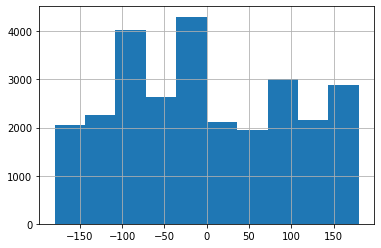

In [ ]:
df.loc[df['Transportation Mode']=='walk']['bearing'].hist()

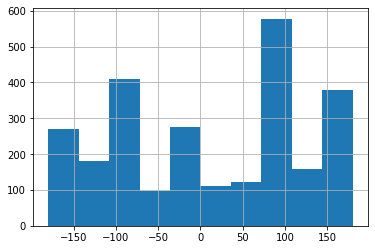

In [ ]:
df.loc[df['Transportation Mode']=='taxi']['bearing'].hist()

### Velocity Walking Versus Taxi

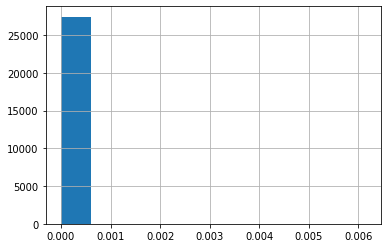

In [ ]:
df.loc[df['Transportation Mode']=='walk']['velocity'].hist()

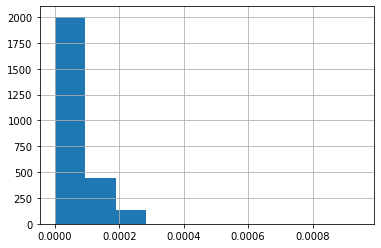

In [ ]:
df.loc[df['Transportation Mode']=='taxi']['velocity'].hist()


### Displacement Lat Walking Versus Taxi

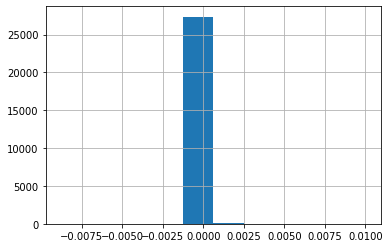

In [ ]:
df.loc[df['Transportation Mode']=='walk']['change_lat'].hist()

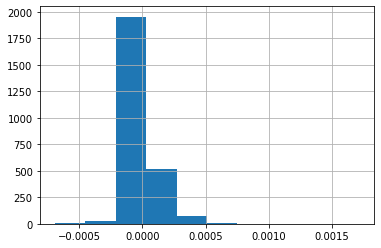

In [ ]:
df.loc[df['Transportation Mode']=='taxi']['change_lat'].hist()

### Displacement Lon Walking Versus Taxi

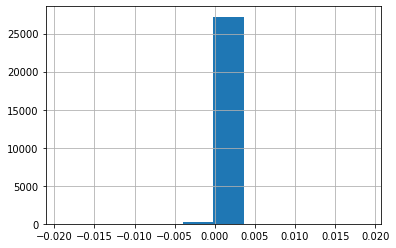

In [ ]:
df.loc[df['Transportation Mode']=='walk']['change_long'].hist()


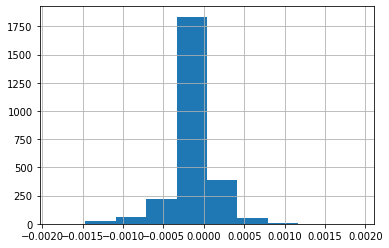

In [ ]:
df.loc[df['Transportation Mode']=='taxi']['change_long'].hist()

### Distance Walking Vs Taxi

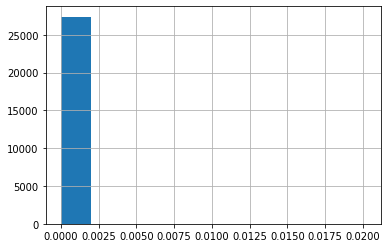

In [ ]:
df.loc[df['Transportation Mode']=='walk']['dist'].hist()

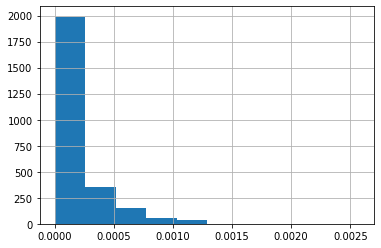

In [ ]:
df.loc[df['Transportation Mode']=='taxi']['dist'].hist()

## Machine Learning
---



### Random Forest 


In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=20)


In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(df[['Transportation Mode']]).toarray())
encoder_df.columns = ['subway', 'taxi', 'walk']
#df.drop(['subway','taxi','walk'],inplace=True, axis=1)
df  = df.join(encoder_df)
df = df.drop_duplicates()


In [ ]:
target_encoder = LabelEncoder()
y_df = pd.DataFrame(target_encoder.fit_transform(df['Transportation Mode']))
y_df

,0
0,2
1,2
2,2
3,2
4,2
...,...
29759,2
29760,2
29761,2
29762,2


In [ ]:
x_df= df[['timestep','dist', 'bearing','velocity','change_long','change_lat']]

X= x_df.to_numpy()
y = y_df[0].to_numpy()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)



(14882, 6) (14882, 6) (14882,) (14882,)


In [ ]:
model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)
yhat = model.predict(X_test)
acc = accuracy_score(y_test, yhat)


In [ ]:
cm = multilabel_confusion_matrix(y_test, yhat, labels=[0,1,2] )
cm

array([[[14839,    12],
        [   31,     0]],

       [[13232,   356],
        [  892,   402]],

       [[  406,   919],
        [  364, 13193]]])

#### Accuracy

In [ ]:
#kfold = KFold(n_splits=10, shuffle=True, random_state=20)

for i, col in enumerate(encoder_df.columns):

    conf_df = pd.DataFrame(cm[i],columns=['Positive','Negative'], index=['Positive','Negatives'])
    fig = px.imshow(conf_df, text_auto=True,title=str(col))
    fig.show()

#print(acc)

#### Cross Validation

In [ ]:
model = RandomForestClassifier(n_estimators=1000)
model.fit(X, y)

results = cross_val_score(model, X, y, cv=kfold)

print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print(pd.DataFrame({'Feature Importance':model.feature_importances_
                    }))


Accuracy: 91.29% (0.45%)
   Feature Importance
0            0.025978
1            0.171135
2            0.348593
3            0.167006
4            0.142790
5            0.144499


### XGBoost

I will write a blurb later on why I chose this and why this works.

#### Accuracy

In [ ]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
acc = accuracy_score(y_test, yhat)

cm = multilabel_confusion_matrix(y_test, yhat, labels=[0,1,2] )

for i, col in enumerate(encoder_df.columns):

    conf_df = pd.DataFrame(cm[i],columns=['Positive','Negative'], index=['Positive','Negatives'])
    fig = px.imshow(conf_df, text_auto=True,title=str(col))
    fig.show()

print(acc)

0.9275634995296331


#### Cross Validation

In [ ]:
clf = xgb.XGBClassifier()

clf.fit(X, y)

results = cross_val_score(clf, X, y, cv=kfold)

print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print(pd.DataFrame({'Feature Importance':clf.feature_importances_
                    }))


Accuracy: 92.77% (0.45%)
   Feature Importance
0            0.103023
1            0.118181
2            0.071635
3            0.484522
4            0.072244
5            0.150395


## Machine Learning Results

In [ ]:
clf = xgb.XGBClassifier()

clf.fit(X_train, y_train)
yhat = clf.predict(X_test)


In [ ]:
traj_df['Unnamed: 0'] = 0
geolife_df = transform_geo_life_df(traj_df)
geolife_df['change_long'] = geolife_df['end_long'] - geolife_df['start_long']

In [ ]:
x_df= geolife_df[['timestep','dist', 'bearing','velocity','start_lat','end_lat','start_long','end_long']]
x_df['change_lat'] = x_df['start_lat'] - x_df['end_lat']
x_df['change_long'] = df['start_long'] - x_df['end_long']
x_df.drop(['start_lat','end_lat','start_long','end_long'],axis=1, inplace=True)
X = x_df.to_numpy()

yhat = clf.predict(X)
yhat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

array([1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
target = pd.DataFrame({'target': yhat})
df = pd.concat([x_df, target, traj_df[['start_point_geom','start_datetime','start_lat','start_long']]],axis=1)
df

,timestep,dist,bearing,velocity,change_lat,change_long,target,start_point_geom,start_datetime,start_lat,start_long
0,2.0,0.000207,-90.361121,0.000104,1.000000e-06,0.000207,1,POINT (39.974821 116.311594),2008-05-20 12:25:00,39.974821,116.311594
1,2.0,0.000174,-93.861334,0.000087,9.000000e-06,0.000174,1,POINT (39.97482 116.311387),2008-05-20 12:25:02,39.974820,116.311387
2,2.0,0.000165,-82.744658,0.000082,-1.600000e-05,0.000164,2,POINT (39.974811 116.311213),2008-05-20 12:25:04,39.974811,116.311213
3,2.0,0.000169,-88.230880,0.000085,-4.000000e-06,0.000169,2,POINT (39.97482700000001 116.311049),2008-05-20 12:25:06,39.974827,116.311049
4,2.0,0.000188,-95.156018,0.000094,1.300000e-05,0.000188,2,POINT (39.974831 116.31088),2008-05-20 12:25:08,39.974831,116.310880
...,...,...,...,...,...,...,...,...,...,...,...
723,2.0,0.000018,102.271776,0.000009,3.000000e-06,0.000000,2,POINT (39.98477800000001 116.352932),2008-05-20 14:22:48,39.984778,116.352932
724,2.0,0.000022,140.740992,0.000011,1.500000e-05,0.000000,2,POINT (39.984775 116.35295),2008-05-20 14:22:50,39.984775,116.352950
725,2.0,0.000032,146.160568,0.000016,2.400000e-05,0.000000,2,POINT (39.98476 116.352966),2008-05-20 14:22:52,39.984760,116.352966
726,2.0,0.000022,103.349024,0.000011,4.000000e-06,0.000000,2,POINT (39.984736 116.352987),2008-05-20 14:22:54,39.984736,116.352987


In [ ]:
def get_points(df, tol):
    point_list = []
    for p in LineString(df['start_point_geom']).simplify(tol).coords:
        point_list.append(Point(p).wkt)
    return point_list

def create_rdp_df(df):
    
    df.reset_index(drop=True, inplace=True)
    hash_map = {1: 0.0001, 2: 0.001, 3: 0.01}
    if len(df) >1:
        val = df[['target']].iloc[0]['target']
        if val == 1:
            rdp_df = pd.DataFrame({'start_point_geom':get_points(df, 0.001)})

        elif val== 2:
            rdp_df = pd.DataFrame({'start_point_geom' : get_points(df, 0.001)})

        elif val== 3:
            rdp_df = pd.DataFrame({'start_point_geom' : get_points(df, 0.01)})
    
        df['start_point_geom'] = df['start_point_geom'].astype(str)
        return df.merge(rdp_df, on='start_point_geom', how='inner')
    else:
        return df

    #df['target'] = df['target'].apply(lambda x:hash_map[x] )




In [ ]:
df_list = []
for k, v  in df[df['target'] == 1].groupby((df['target'] != 1).cumsum()):

    rdp = create_rdp_df(v)
    df_list.append(v)

simp_df = pd.concat(df_list,ignore_index=True)
simp_df

,timestep,dist,bearing,velocity,change_lat,change_long,target,start_point_geom,start_datetime,start_lat,start_long
0,2.0,0.000207,-90.361121,0.000104,1.000000e-06,0.000207,1,POINT (39.974821 116.311594),2008-05-20 12:25:00,39.974821,116.311594
1,2.0,0.000174,-93.861334,0.000087,9.000000e-06,0.000174,1,POINT (39.97482 116.311387),2008-05-20 12:25:02,39.974820,116.311387
2,2.0,0.000219,-99.222228,0.000109,2.700000e-05,0.000217,1,POINT (39.974818 116.310692),2008-05-20 12:25:10,39.974818,116.310692
3,2.0,0.000220,-97.803529,0.000110,2.300000e-05,0.000219,1,POINT (39.974791 116.310475),2008-05-20 12:25:12,39.974791,116.310475
4,2.0,0.000221,-93.379114,0.000111,1.000000e-05,0.000221,1,POINT (39.974768 116.310256),2008-05-20 12:25:14,39.974768,116.310256
...,...,...,...,...,...,...,...,...,...,...,...
122,2.0,0.000275,81.838180,0.000137,-3.000000e-05,0.000000,1,POINT (39.985292 116.350473),2008-05-20 14:20:26,39.985292,116.350473
123,2.0,0.000266,84.933880,0.000133,-1.800000e-05,0.000000,1,POINT (39.985322 116.350746),2008-05-20 14:20:28,39.985322,116.350746
124,2.0,0.000249,85.186868,0.000124,-1.600000e-05,0.000000,1,POINT (39.98534 116.351011),2008-05-20 14:20:30,39.985340,116.351011
125,2.0,0.000233,90.962645,0.000117,3.000000e-06,0.000000,1,POINT (39.985356 116.351259),2008-05-20 14:20:32,39.985356,116.351259


## Final Plot

In [ ]:
tdf = skmob.TrajDataFrame(simp_df, latitude='start_lat',longitude='start_long', datetime = 'start_datetime')
tdf.plot_trajectory(zoom=12, weight=1, opacity=0.9)


/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning:

If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.



## Data Reduction Amount

In [ ]:
data_reduction = (1-(len(simp_df)/len(df)))*100
print("Reduced the data by {0}%.".format((data_reduction)))

Reduced the data by 82.55494505494505%.




# To Be Continued

- Looking at State Space Models to reduce error first then applyging the RDP to reduce data. 
- Breaking down different kinds of clusters, for different types of behaviors with semi-unsupervised clustering algorithms.

# References:
1. Puzzo, L. (2021, July 22). GPS accuracy and GPS drift - should you rely on it anymore? - mosaic51. Mosaic51.com. Retrieved April 11, 2022, from https://www.mosaic51.com/community/gps-accuracy-and-gps-drift-should-you-rely-on-it-anymore/ 

# Citations:

- https://arxiv.org/abs/1704.05964
- https://dalspace.library.dal.ca/bitstream/handle/10222/79941/Etemad-Mohammad-PHD-ComputerScience-Sep-2020.pdf?sequence=1
- https://movementecologyjournal.biomedcentral.com/articles/10.1186/s40462-016-0086-5
- https://www.microsoft.com/en-us/research/publication/tutorial-on-location-based-social-networks/
- https://asset-pdf.scinapse.io/prod/1626398438/1626398438.pdf
- https://link.springer.com/article/10.1007/s41060-016-0014-1
- http://kth.diva-portal.org/smash/get/diva2:1376904/FULLTEXT01.pdf
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5876950/
- https://josis.org/index.php/josis/article/view/46/46
- https://www.sciencedirect.com/science/article/abs/pii/S0021929004002258?via%3Dihub

# Data Citations

- https://github.com/jbremz/Beijing-Trajectories-Project/tree/master/Example%20Data/028/Trajectory
- https://github.com/jmharkins/trajectory-data
- https://github.com/jbremz/Beijing-Trajectories-Project/blob/master/Classification/Classification%20Notes.ipynb

# For a Rainy Day
Equations:

$z = \frac {x-\overline{x}}{σ}$

$y[i] = \sum_{k=1}^i x[k], \text{ for } i=1, 2, \dots, N$ where the index n is where $|z|> 1$